In [176]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

## Stock Selection

In [177]:
# Define stock ticker and date range
stock_ticker = 'MCK'
stock_start_date = datetime.date(2014,1,1)
stock_end_date = datetime.date.today()

# Fetch the stock price from Yahoo Finance using yfinance
stock_df = yf.download(stock_ticker, start=stock_start_date, end=stock_end_date)

[*********************100%***********************]  1 of 1 completed


In [178]:
stock_df

Price,Close,High,Low,Open,Volume
Ticker,MCK,MCK,MCK,MCK,MCK
Date,,,,,
2014-01-02,147.309677,148.073084,146.656637,147.944318,847000
2014-01-03,147.815506,149.093979,147.263641,147.392408,2156200
2014-01-06,147.401672,153.177801,147.079763,152.782308,2017900
2014-01-07,148.845627,150.234467,147.226845,147.843086,2215400
2014-01-08,156.185394,159.193032,152.313189,152.681090,5450100
...,...,...,...,...,...
2025-01-24,591.580017,598.059998,586.530029,598.059998,570900
2025-01-27,604.429993,604.859985,592.520020,596.750000,670300


In [179]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2014-01-02 to 2025-01-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, MCK)   2787 non-null   float64
 1   (High, MCK)    2787 non-null   float64
 2   (Low, MCK)     2787 non-null   float64
 3   (Open, MCK)    2787 non-null   float64
 4   (Volume, MCK)  2787 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 130.6 KB


In [180]:
stock_df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2025-01-16', '2025-01-17', '2025-01-21', '2025-01-22',
               '2025-01-23', '2025-01-24', '2025-01-27', '2025-01-28',
               '2025-01-29', '2025-01-30'],
              dtype='datetime64[ns]', name='Date', length=2787, freq=None)

In [181]:
stock_df.columns

MultiIndex([( 'Close', 'MCK'),
            (  'High', 'MCK'),
            (   'Low', 'MCK'),
            (  'Open', 'MCK'),
            ('Volume', 'MCK')],
           names=['Price', 'Ticker'])

In [182]:
stock_df.columns = stock_df.columns.map(' '.join).str.replace(' ','')
stock_df

,CloseMCK,HighMCK,LowMCK,OpenMCK,VolumeMCK
Date,,,,,
2014-01-02,147.309677,148.073084,146.656637,147.944318,847000
2014-01-03,147.815506,149.093979,147.263641,147.392408,2156200
2014-01-06,147.401672,153.177801,147.079763,152.782308,2017900
2014-01-07,148.845627,150.234467,147.226845,147.843086,2215400
2014-01-08,156.185394,159.193032,152.313189,152.681090,5450100
...,...,...,...,...,...
2025-01-24,591.580017,598.059998,586.530029,598.059998,570900
2025-01-27,604.429993,604.859985,592.520020,596.750000,670300
2025-01-28,602.950012,607.830017,597.090027,606.260010,602800


In [183]:
stock_df = stock_df[['CloseMCK']]
stock_df

,CloseMCK
Date,
2014-01-02,147.309677
2014-01-03,147.815506
2014-01-06,147.401672
2014-01-07,148.845627
2014-01-08,156.185394
...,...
2025-01-24,591.580017
2025-01-27,604.429993
2025-01-28,602.950012


## Economic Factors Data

Source of Data: 
Federal Reserve Economic Data | FRED | St. Louis Fed (https://fred.stlouisfed.org/)
Bureau of Labor Statistics (https://data.bls.gov/timeseries/LNS14000000)

1. Interest Rate
Interest rates, set by central banks, have a direct and profound impact on stock prices. Higher interest rates increase the cost of borrowing for companies, which can reduce their profitability and, in turn, lower their stock prices. Conversely, lower interest rates make borrowing cheaper, potentially boosting corporate earnings and stock prices. Higher interest rates make fixed-income investments (e.g., bonds) more attractive compared to stocks, leading investors to shift their portfolios away from equities. This can reduce demand for stocks and lower stock prices. Lower interest rates, on the other hand, make stocks more appealing. Besides, interest rates influence economic growth. Lower rates stimulate spending and investment, which can boost corporate earnings and stock prices. Higher rates can slow economic growth, negatively impacting earnings and stock prices.

2. Unemployment Rate
The unemployment rate is a key indicator of economic health and consumer spending. Higher unemployment reduces disposable income and consumer spending, which can hurt companies' revenues and profitability, leading to lower stock prices. Lower unemployment typically boosts consumer spending, supporting corporate earnings and stock prices. Companies in sectors like retail, hospitality, and consumer goods are particularly sensitive to changes in unemployment. Higher unemployment can lead to reduced demand for their products, negatively impacting their stock prices.
 High unemployment can signal economic weakness, leading to pessimistic investor sentiment and lower stock prices. Conversely, low unemployment can boost confidence in the economy and drive stock prices higher. Lower unemployment can lead to higher wages as companies compete for workers, potentially squeezing profit margins. This can negatively impact stock prices, especially for labor-intensive industries.

3. CPI (Consumer Price Index)
The CPI measures inflation. High inflation erodes consumers' purchasing power, reducing demand for goods and services. This can hurt corporate revenues and earnings, leading to lower stock prices. Moderate inflation, however, can indicate a healthy economy and support stock prices.Inflation increases the cost of raw materials and other inputs for companies. If companies cannot pass these costs onto consumers, their profit margins may shrink, negatively impacting stock prices. Central banks often raise interest rates to combat high inflation. As discussed earlier, higher interest rates can negatively affect stock prices. Conversely, low inflation may lead to lower interest rates, which can support stock prices. Different sectors react differently to inflation. For example, sectors like energy and commodities may benefit from inflation, while consumer discretionary sectors may suffer. Understanding CPI trends can help predict sector-specific stock performance.

Econ Factor 1: Unemployment Rate

In [184]:
econ1_df = pd.read_excel('unemployment_data.xlsx', index_col=None)
econ1_df = econ1_df.rename(columns={'Value': 'Unemployment Rate'})
econ1_df

,Date,Unemployment Rate
0,2014-01,6.6
1,2014-02,6.7
2,2014-03,6.7
3,2014-04,6.2
4,2014-05,6.3
...,...,...
127,2024-08,4.2
128,2024-09,4.1
129,2024-10,4.1
130,2024-11,4.2


In [185]:
econ1_df['Date'] = pd.to_datetime(econ1_df['Date'] + '-01')
econ1_df.set_index('Date', inplace=True)
econ1_df.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=132, freq=None)

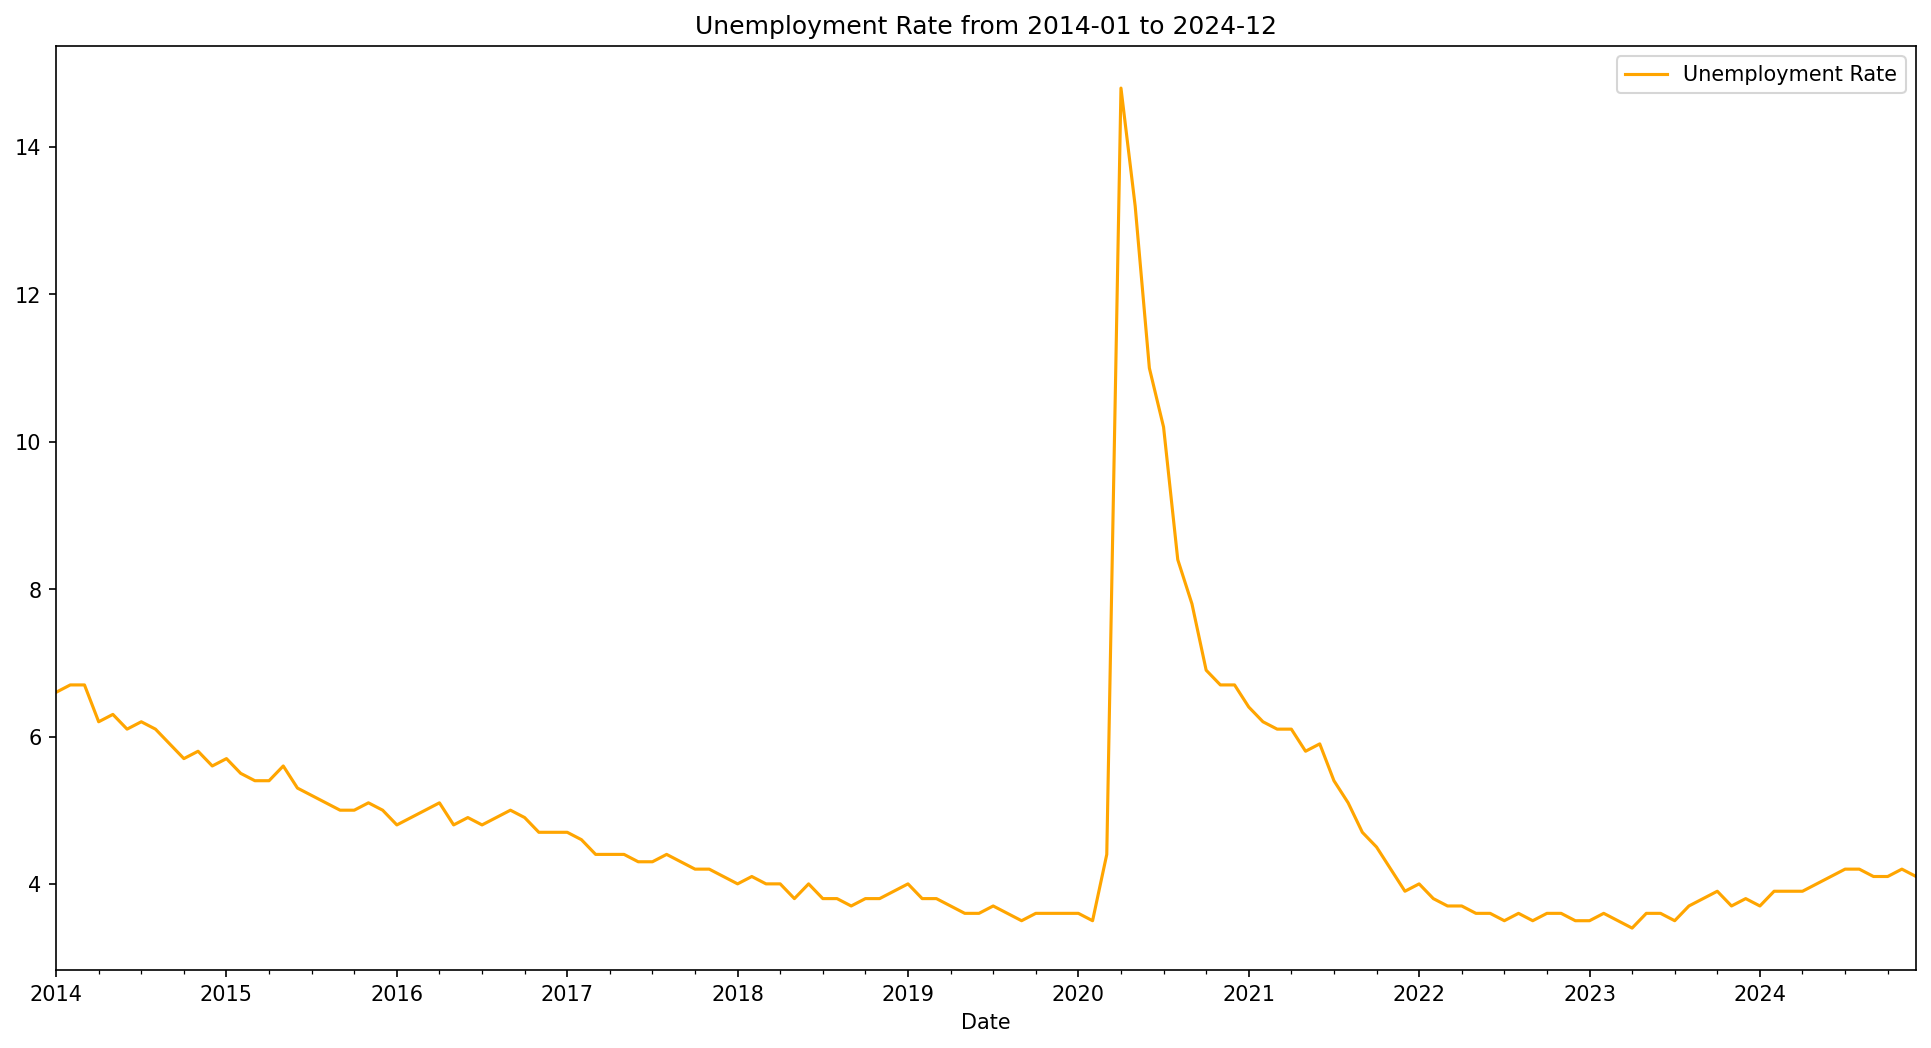

In [186]:
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

econ1_df['Unemployment Rate'].plot(label='Unemployment Rate', color='orange')

plt.title('Unemployment Rate from {} to {}'.format('2014-01', '2024-12'))
plt.xlabel('Date')
plt.legend()

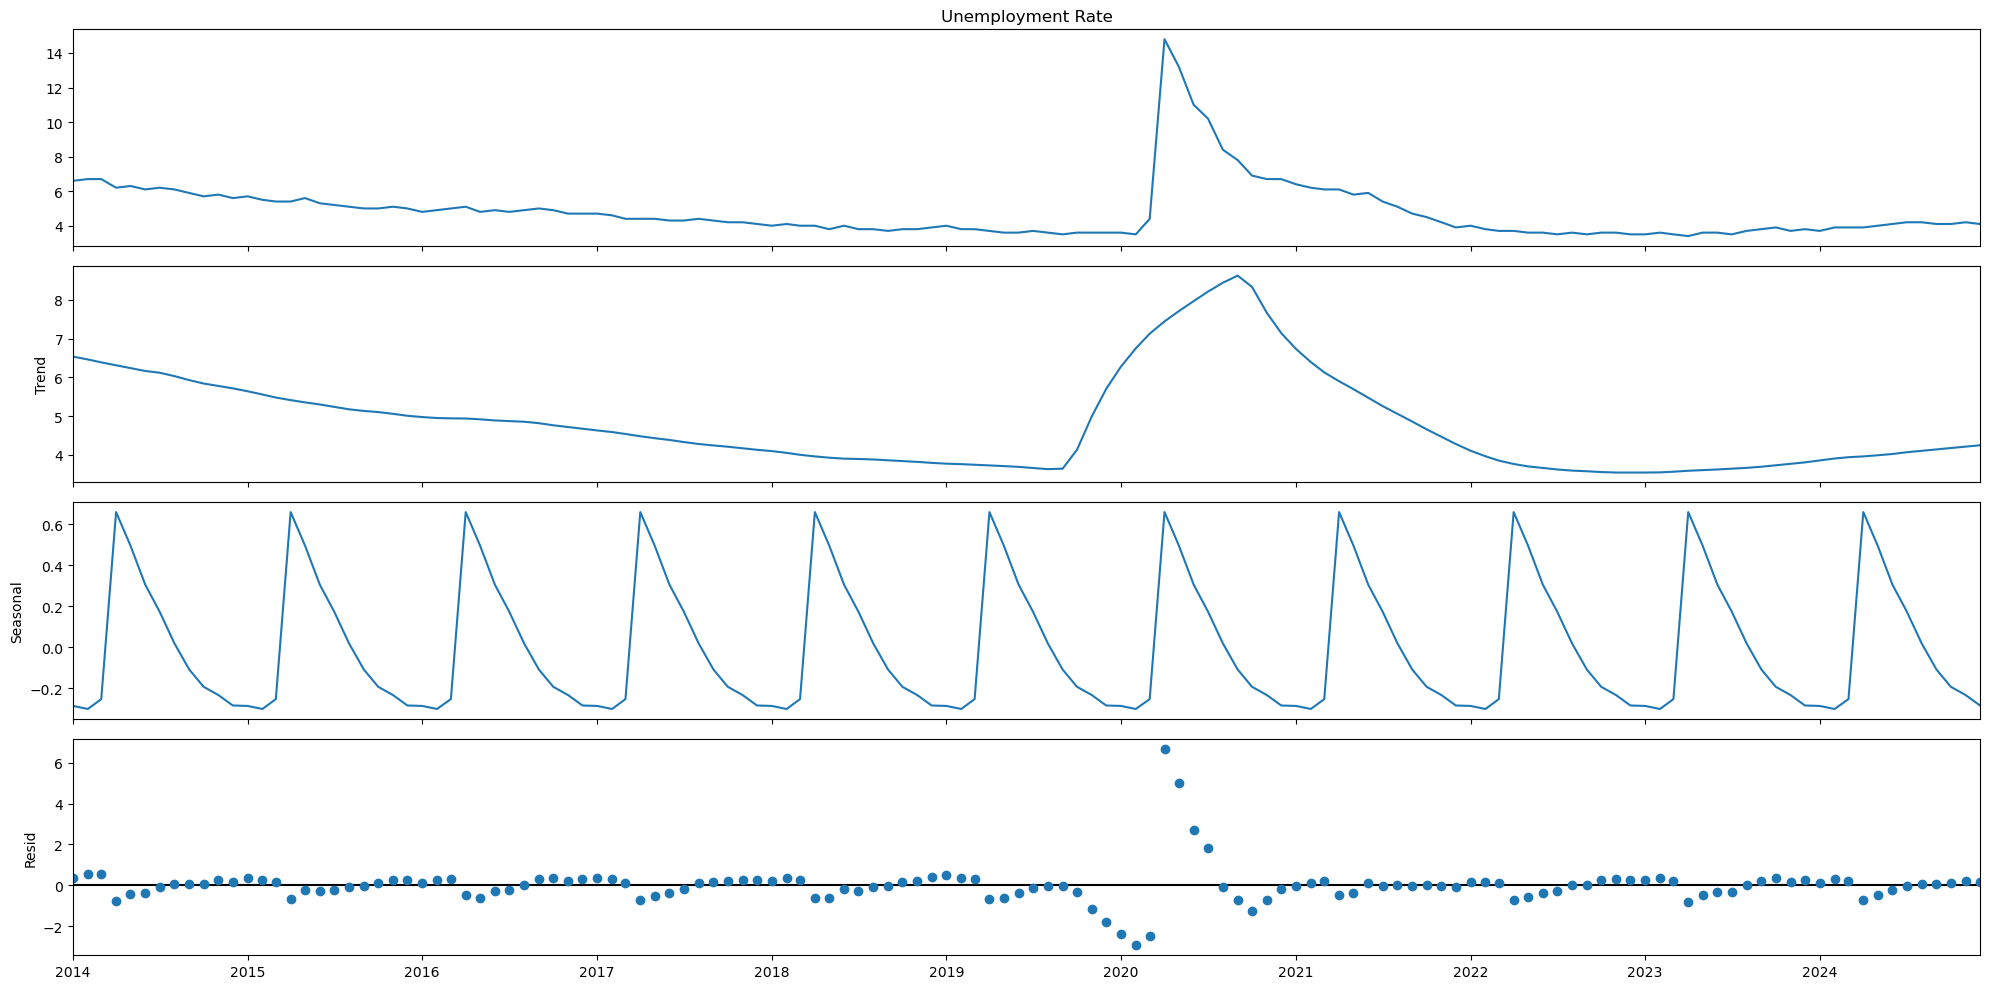

In [187]:
res1 = sm.tsa.seasonal_decompose(econ1_df['Unemployment Rate'], period=12, extrapolate_trend='freq')
fig1 = res1.plot()
fig1.set_size_inches((20, 10))
fig1.tight_layout()
plt.show()

Economic Factor 2: CPI-U Consumer Price Index For All Urban Consumers

In [188]:
econ2_df = pd.read_excel('cpi_data.xlsx', index_col=None)
econ2_df = econ2_df.rename(columns={'Value': 'CPI'})
econ2_df

,Date,CPI
0,2014-01,1.6
1,2014-02,1.6
2,2014-03,1.7
3,2014-04,1.8
4,2014-05,2.0
...,...,...
127,2024-08,3.2
128,2024-09,3.3
129,2024-10,3.3
130,2024-11,3.3


In [189]:
econ2_df['Date'] = pd.to_datetime(econ2_df['Date'] + '-01')
econ2_df.set_index('Date', inplace=True)
econ2_df.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=132, freq=None)

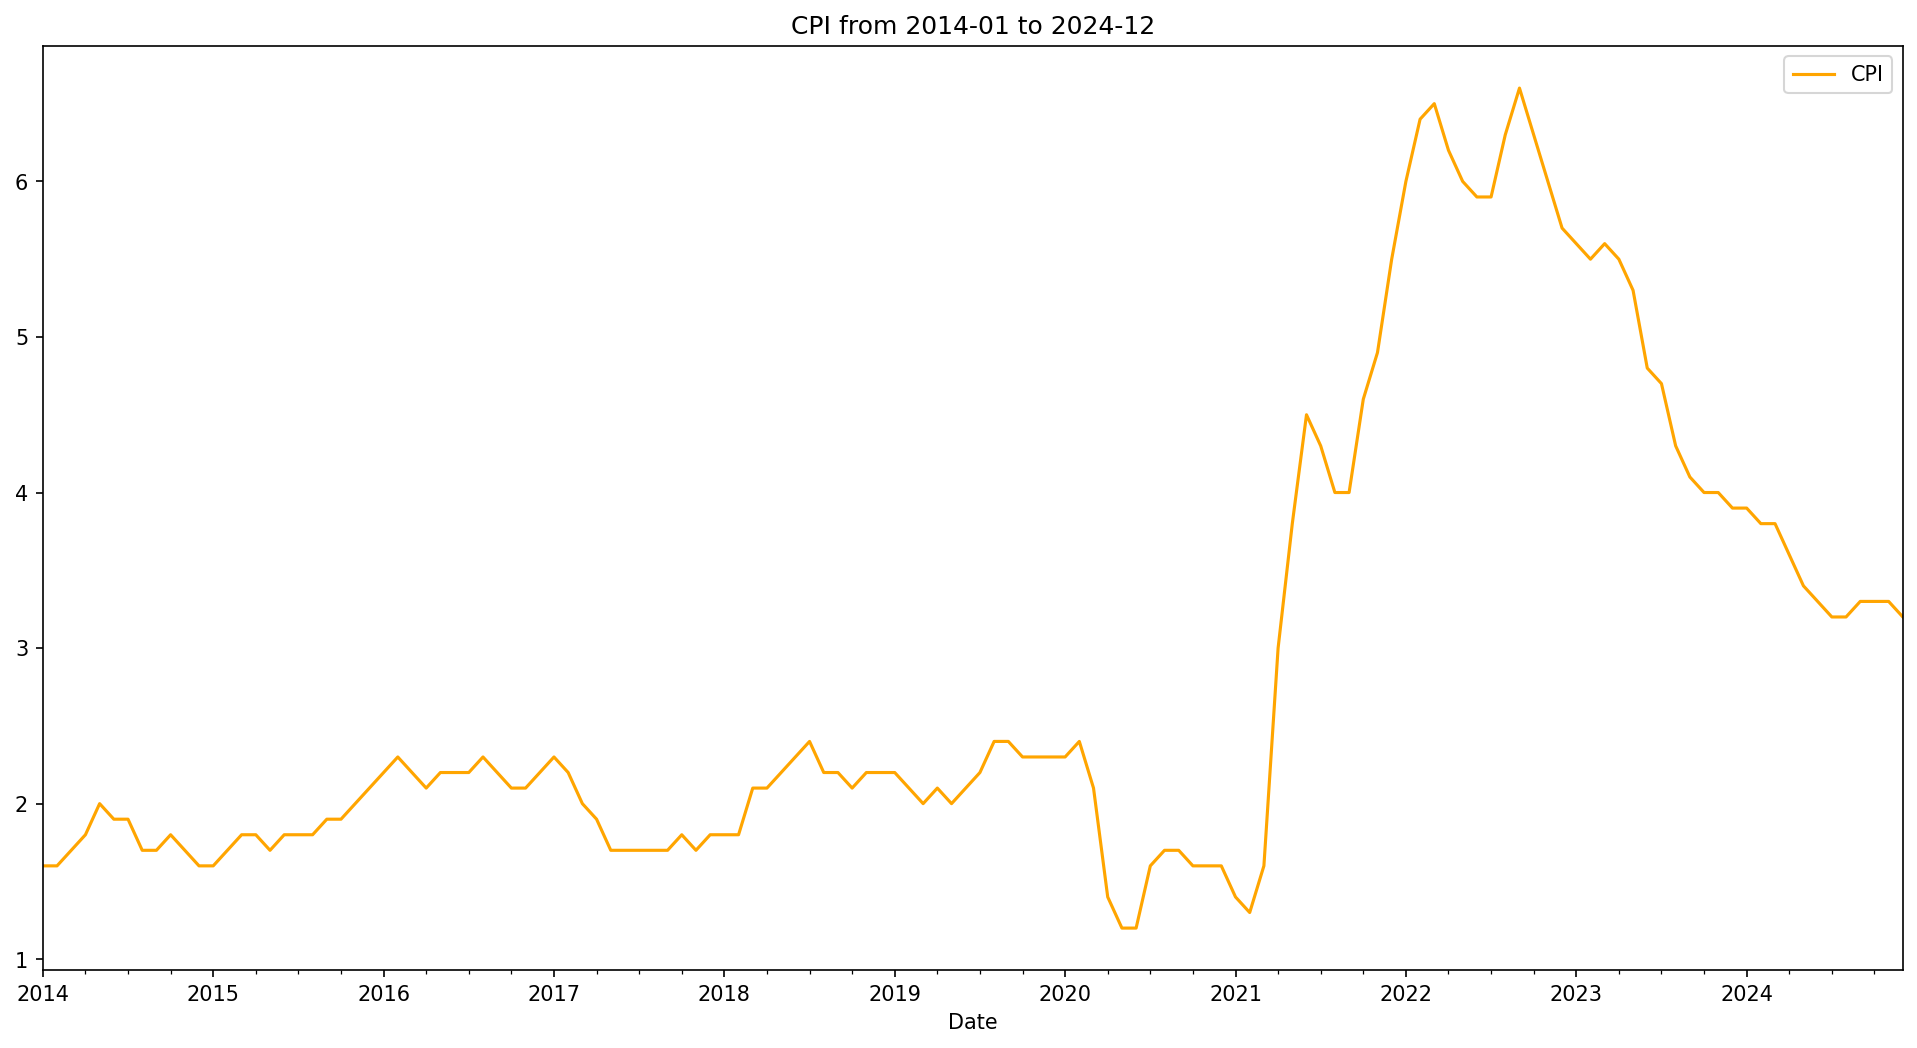

In [190]:
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

econ2_df['CPI'].plot(label='CPI', color='orange')

plt.title('CPI from {} to {}'.format('2014-01', '2024-12'))
plt.xlabel('Date')
plt.legend()

Economic Factor 3: Federal Fund Rate (Interest Rate)

In [191]:
econ3_df = pd.read_excel('FEDFUNDS.xlsx')
econ3_df = econ3_df.rename(columns={'FEDFUNDS': 'Interest Rate'})
econ3_df

,Date,Interest Rate
0,2014-01-01,0.07
1,2014-02-01,0.07
2,2014-03-01,0.08
3,2014-04-01,0.09
4,2014-05-01,0.09
...,...,...
127,2024-08-01,5.33
128,2024-09-01,5.13
129,2024-10-01,4.83
130,2024-11-01,4.64


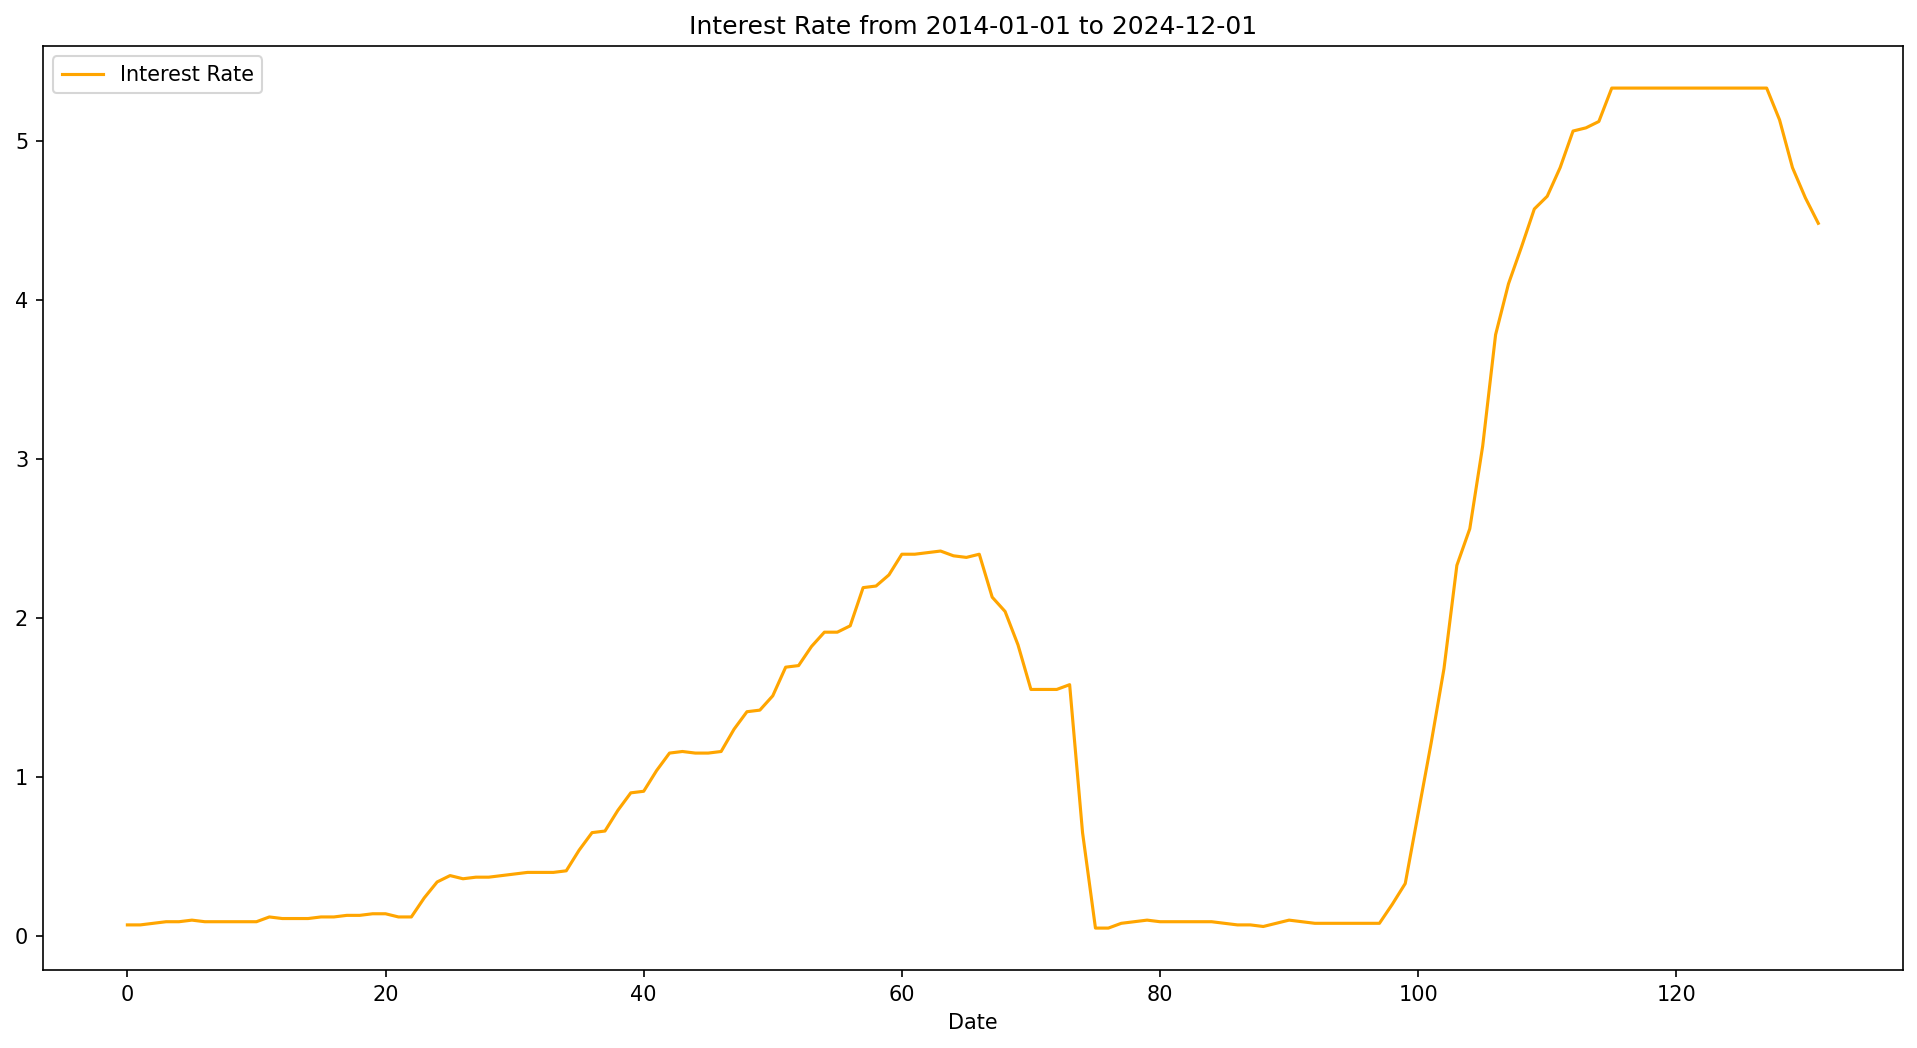

In [192]:
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

econ3_df['Interest Rate'].plot(label='Interest Rate', color='orange')

plt.title('Interest Rate from 2014-01-01 to 2024-12-01')
plt.xlabel('Date')
plt.legend()

## Relationship between Economic Factors and Chosen Stock

Unemployment Rate And Stock MCK Price

In [193]:
econ1_stock = pd.merge(econ1_df, stock_df, on="Date")
econ1_stock

,Unemployment Rate,CloseMCK
Date,,
2014-04-01,6.2,162.138153
2014-05-01,6.3,154.917282
2014-07-01,6.2,174.719391
2014-08-01,6.1,180.224884
2014-10-01,5.7,177.809601
...,...,...
2024-05-01,4.0,529.246094
2024-07-01,4.2,584.929932
2024-08-01,4.2,627.577148


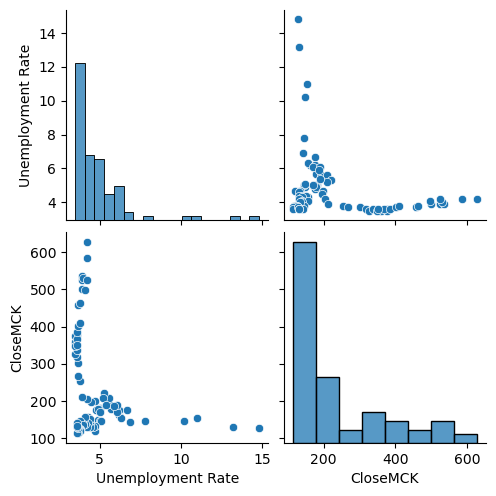

In [194]:
sns.pairplot(econ1_stock)

In [195]:
np.corrcoef(econ1_stock['Unemployment Rate'],econ1_stock['CloseMCK'])

array([[ 1.        , -0.30354586],
       [-0.30354586,  1.        ]])

<Axes: xlabel='Date'>

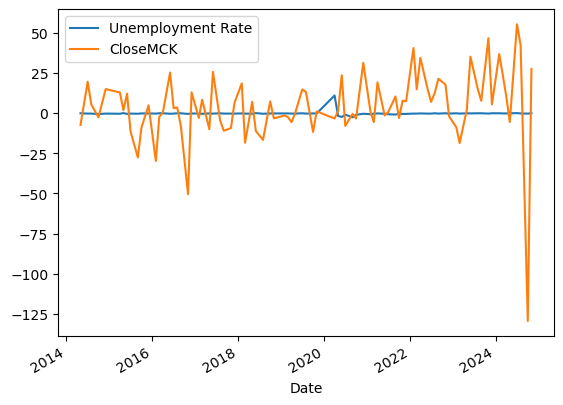

In [196]:
differenced_econ1 = econ1_stock.diff()
differenced_econ1.plot()

In [197]:
np.corrcoef(differenced_econ1['Unemployment Rate'].dropna(),differenced_econ1['CloseMCK'].dropna())

array([[ 1.        , -0.02391988],
       [-0.02391988,  1.        ]])


The relationship between the unemployment rate and MCK’s stock price appears weak, based on the provided data and analysis. The correlation coefficient of -0.30 suggests a slight negative relationship, meaning that as the unemployment rate rises, MCK’s stock price tends to decrease. However, this correlation is not strong enough to be considered a reliable predictor of stock price movements.

Visualization techniques further confirm this weak relationship. A pairplot illustrates no clear linear or non-linear pattern between the unemployment rate and MCK’s stock price, with data points scattered rather than forming a distinct trend. Additionally, a differenced data plot shows that changes in unemployment and stock price do not follow a consistent pattern, reinforcing the idea that other variables likely have a more significant impact.

When assessing the predictive quality of these variables, it becomes evident that the unemployment rate alone is not sufficient for forecasting MCK’s stock price. While there is a weak inverse relationship, company-specific metrics, industry trends, and broader macroeconomic indicators likely play a more substantial role. Similarly, MCK’s stock price does not serve as a strong predictor of unemployment rate changes, as there is no clear causal relationship between the two.

Moreover, analyzing the differenced data reveals a correlation coefficient of -0.0239, which is very close to zero. This indicates that short-term fluctuations in unemployment do not significantly influence short-term changes in MCK’s stock price, and vice versa.

Therefore, the unemployment rate and MCK’s stock price share a weak negative relationship but are not strong predictors of each other. To improve stock price forecasting, incorporating additional economic indicators such as GDP, interest rates, or industry trends would likely yield better results.

Consumer Price Index And Stock MCK Price

In [199]:
econ2_stock = pd.merge(econ2_df, stock_df, on="Date")
econ2_stock

,CPI,CloseMCK
Date,,
2014-04-01,1.8,162.138153
2014-05-01,2.0,154.917282
2014-07-01,1.9,174.719391
2014-08-01,1.7,180.224884
2014-10-01,1.8,177.809601
...,...,...
2024-05-01,3.4,529.246094
2024-07-01,3.2,584.929932
2024-08-01,3.2,627.577148


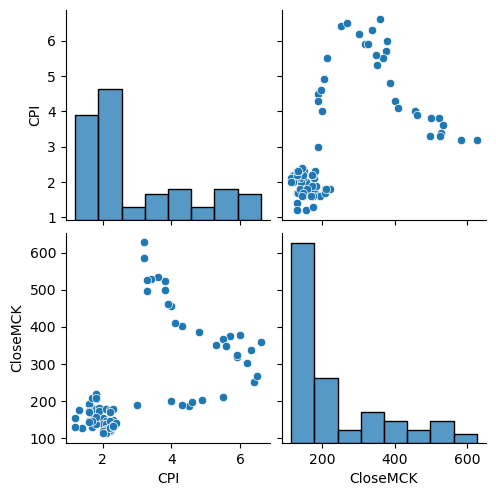

In [200]:
sns.pairplot(econ2_stock)

In [201]:
np.corrcoef(econ2_stock['CPI'],econ2_stock['CloseMCK'])

array([[1.        , 0.56752074],
       [0.56752074, 1.        ]])

<Axes: xlabel='Date'>

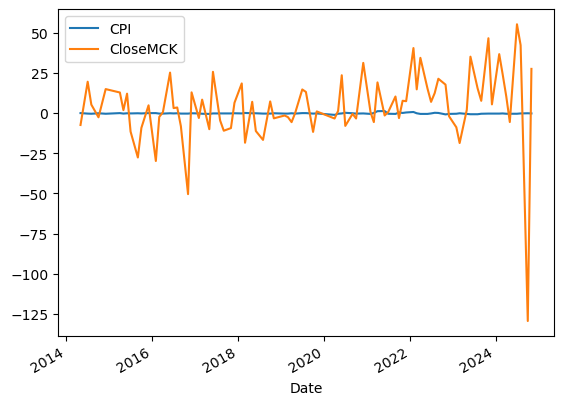

In [202]:
differenced_econ2 = econ2_stock.diff()
differenced_econ2.plot()

In [203]:
np.corrcoef(differenced_econ2['CPI'].dropna(),differenced_econ2['CloseMCK'].dropna())

array([[ 1.        , -0.02691343],
       [-0.02691343,  1.        ]])

The analysis of the relationship between Consumer Price Index (CPI) and MCK stock closing prices reveals a complex and largely unpredictable connection. While initial data suggests a moderate positive correlation (0.5675), this relationship proves misleading when examined more closely through various statistical methods.

When the data is made stationary through differencing, the correlation drops dramatically to -0.0269, indicating virtually no relationship between CPI changes and stock price movements. The visualization shows stable, small changes in CPI contrasting with highly volatile MCK stock prices, suggesting different underlying drivers for each variable.

The pair plot analysis reveals a non-linear relationship where MCK stock prices initially rise with CPI increases but later decline despite higher CPI values. The distribution patterns show clustered CPI values (2-3.5 range) versus widely distributed stock prices, further highlighting their disconnected nature.

Autocorrelation analysis of MCK stock prices shows weak correlations at most lags, with values primarily falling within confidence bands. This suggests that even past stock prices aren't reliable predictors of future values.

These findings indicate that CPI is a poor predictor of MCK stock prices for several reasons: the near-zero true correlation after removing trends, the likely spurious nature of the initial correlation due to trending data, and the stark difference in volatility patterns between the two variables. For meaningful stock price prediction, additional economic indicators and market factors would need to be considered.

Interest Rate And Stock MCK Price

In [205]:
econ3_stock = pd.merge(econ3_df, stock_df, on="Date")
econ3_stock

,Date,Interest Rate,CloseMCK
0,2014-04-01,0.09,162.138153
1,2014-05-01,0.09,154.917282
2,2014-07-01,0.09,174.719391
3,2014-08-01,0.09,180.224884
4,2014-10-01,0.09,177.809601
...,...,...,...
81,2024-05-01,5.33,529.246094
82,2024-07-01,5.33,584.929932
83,2024-08-01,5.33,627.577148
84,2024-10-01,4.83,497.916870


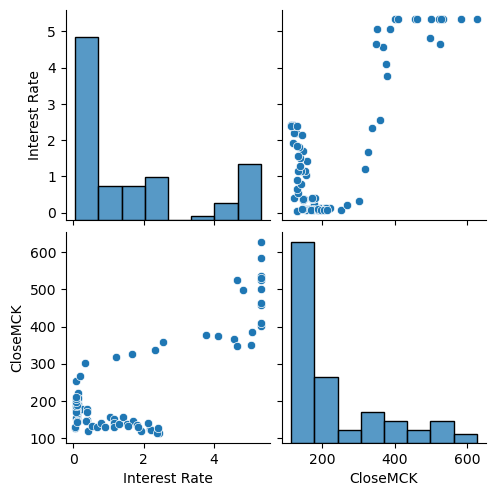

In [206]:
sns.pairplot(econ3_stock)

In [207]:
np.corrcoef(econ3_stock['Interest Rate'],econ3_stock['CloseMCK'])

array([[1.        , 0.80610098],
       [0.80610098, 1.        ]])

<Axes: >

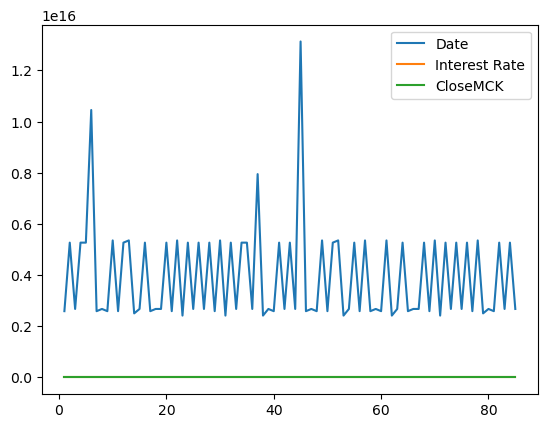

In [208]:
differenced_econ3 = econ3_stock.diff()
differenced_econ3.plot()

In [209]:
np.corrcoef(differenced_econ3['Interest Rate'].dropna(),differenced_econ3['CloseMCK'].dropna())

array([[1.        , 0.20044863],
       [0.20044863, 1.        ]])

Based on the provided data and outputs, we can assess the relationship between the interest rate and the stock price of MCK in detail. The correlation coefficient between the interest rate and MCK's stock price is 0.806, indicating a strong positive relationship. This means that as interest rates increase, MCK's stock price tends to increase as well, and vice versa. This strong correlation suggests that interest rates could be a good predictor of MCK's stock price. The pairplot visualization further confirms this relationship, showing a clear upward trend where higher interest rates are associated with higher stock prices for MCK. This visual trend reinforces the idea that interest rates have a significant influence on MCK's stock price.

When examining the differenced data, which represents the changes in both the interest rate and MCK's stock price over time, the correlation coefficient drops to 0.200. This indicates a moderate positive relationship between short-term changes in interest rates and short-term changes in MCK's stock price. While the relationship is not as strong as the overall correlation, it still suggests that short-term fluctuations in interest rates have some influence on MCK's stock price movements. This difference between the overall and differenced correlations highlights that while long-term trends show a strong relationship, short-term changes are less predictable.

In assessing the predictor quality, the interest rate emerges as a strong predictor of MCK's stock price. The strong positive correlation indicates that interest rates play a significant role in determining MCK's stock price, likely due to factors such as the cost of borrowing, investor behavior, and broader macroeconomic conditions. Conversely, MCK's stock price could also serve as a predictor of interest rates, though this relationship is likely more complex and influenced by additional variables. Overall, the interest rate is a valuable variable to include in predictive models for MCK's stock price, especially when considering long-term trends. However, for short-term predictions, other factors may need to be incorporated to improve accuracy.

## Exploratory Data Analysis

### Descriptive Statistics

In [211]:
stock_df.describe()

,CloseMCK
count,2787.000000
mean,233.315146
std,134.146270
min,103.156609
25%,141.262665
50%,174.839188
75%,306.969437
max,628.864014


<Axes: >

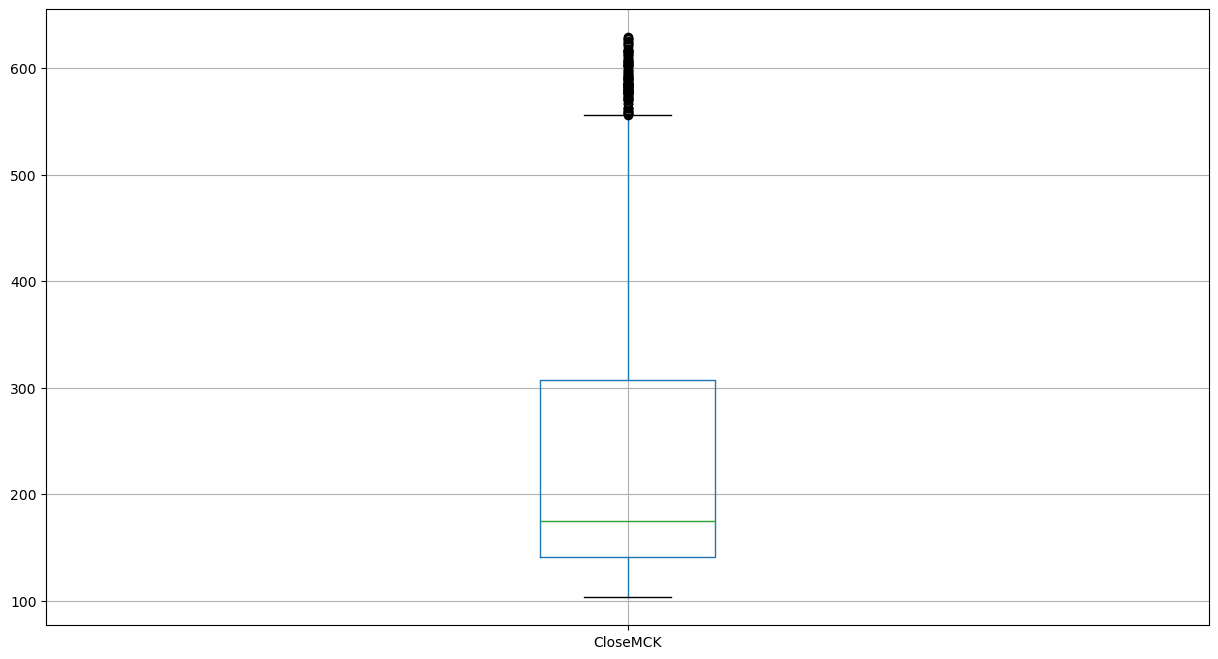

In [212]:
plt.figure(figsize=(15,8))
stock_df.boxplot()

### Missing Data & Imputation

In [213]:
stock_df.isnull().sum()

CloseMCK    0
dtype: int64

In [214]:
#Find the indexes that are missing
pd.date_range(start = '2014-01-01', end = stock_end_date).difference(stock_df.index)

DatetimeIndex(['2014-01-01', '2014-01-04', '2014-01-05', '2014-01-11',
               '2014-01-12', '2014-01-18', '2014-01-19', '2014-01-20',
               '2014-01-25', '2014-01-26',
               ...
               '2025-01-05', '2025-01-09', '2025-01-11', '2025-01-12',
               '2025-01-18', '2025-01-19', '2025-01-20', '2025-01-25',
               '2025-01-26', '2025-01-31'],
              dtype='datetime64[ns]', length=1262, freq=None)

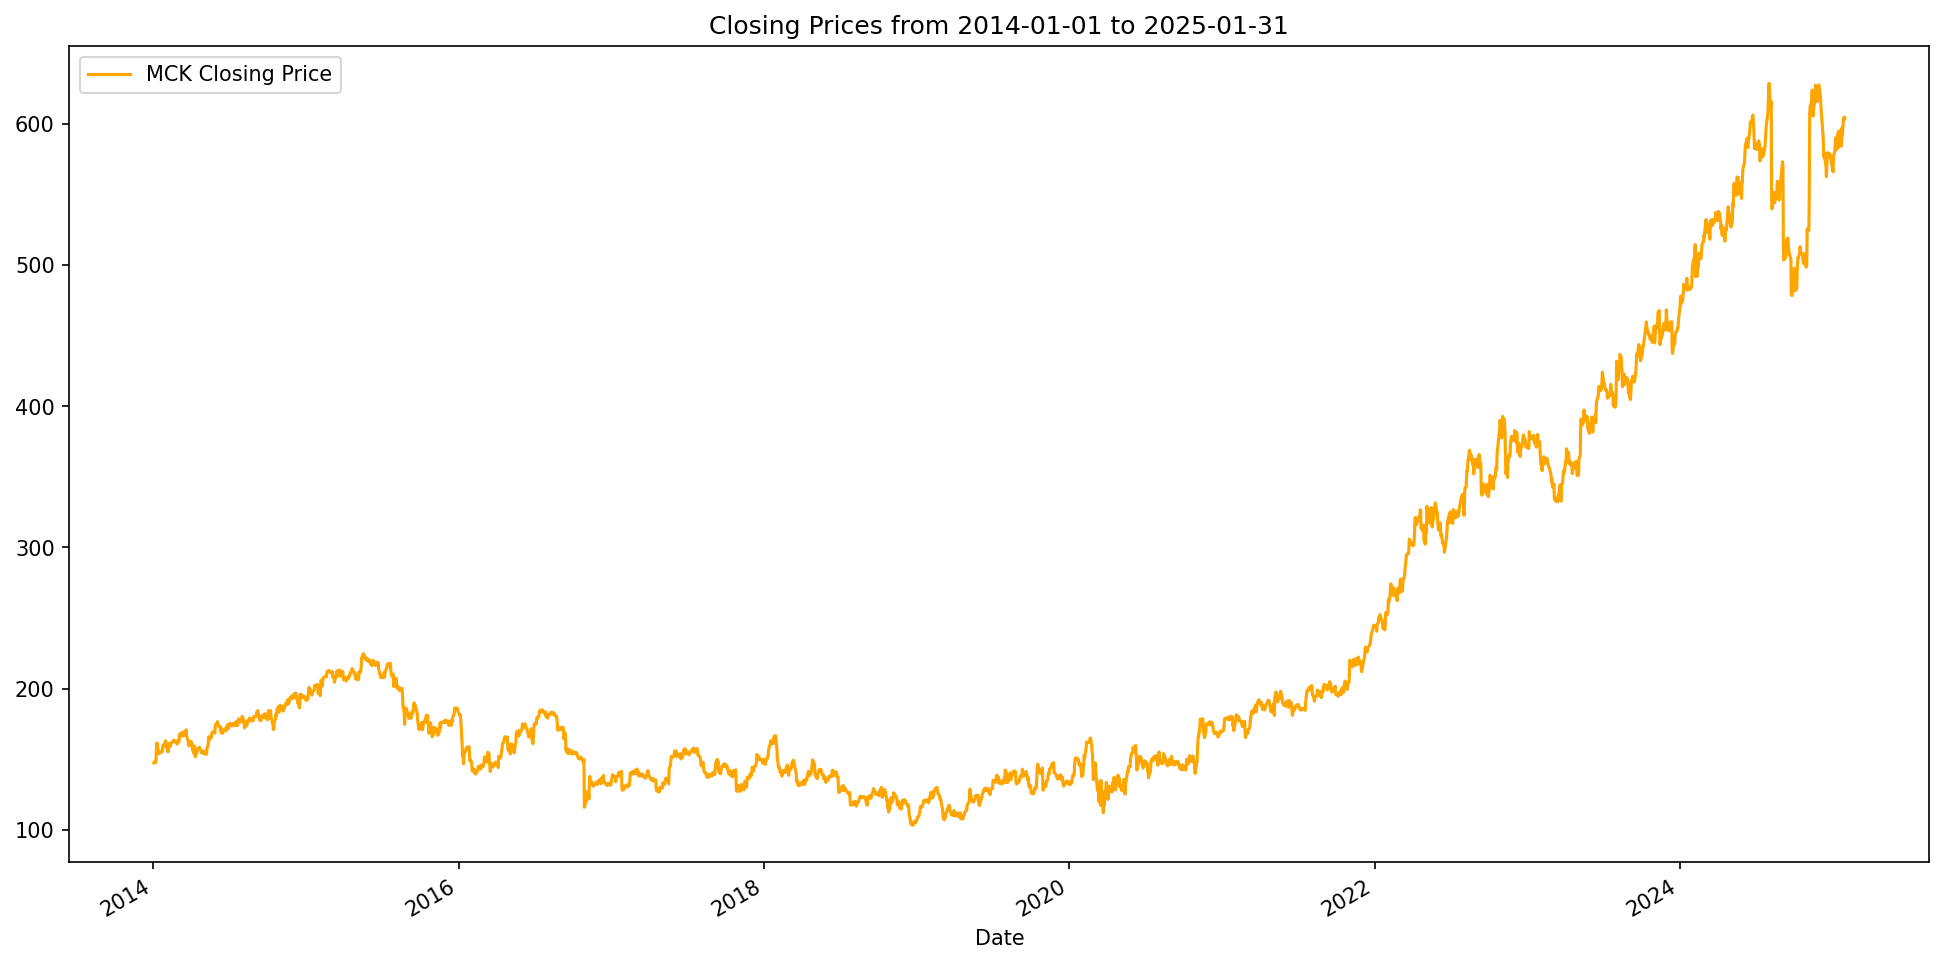

In [215]:
# Visualizing The Close Price of the stocks

plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

stock_df['CloseMCK'].plot(label='MCK Closing Price', color='orange')
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

In [216]:
stock_df_NaN = stock_df.reindex(pd.date_range('2014-01-01', stock_end_date), fill_value= np.NaN)
stock_df_NaN

,CloseMCK
2014-01-01,NaN
2014-01-02,147.309677
2014-01-03,147.815506
2014-01-04,NaN
2014-01-05,NaN
...,...
2025-01-27,604.429993
2025-01-28,602.950012
2025-01-29,603.179993
2025-01-30,604.599976


In [217]:
stock_df_imputed = stock_df_NaN.copy()
stock_df_imputed['MCK_Spline']= stock_df_imputed['CloseMCK'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
#stock_df_imputed['MCK_Linear']= stock_df_imputed['CloseMCK'].interpolate(method='linear', order=1, limit=10, limit_direction='both')
#stock_df_imputed['MCK_ffill']= stock_df_imputed['CloseMCK'].fillna(method ='ffill')
#stock_df_imputed['MCK_bfill']= stock_df_imputed['CloseMCK'].fillna(method ='bfill')
#stock_df_imputed['MCK_Mean']= stock_df_imputed['CloseMCK'].fillna(stock_df_imputed['CloseMCK'].mean())
#stock_df_imputed['MCK_Median']= stock_df_imputed['CloseMCK'].fillna(stock_df_imputed['CloseMCK'].median())
stock_df_imputed.round(2)

,CloseMCK,MCK_Spline
2014-01-01,NaN,146.96
2014-01-02,147.31,147.31
2014-01-03,147.82,147.82
2014-01-04,NaN,147.87
2014-01-05,NaN,148.17
...,...,...
2025-01-27,604.43,604.43
2025-01-28,602.95,602.95
2025-01-29,603.18,603.18
2025-01-30,604.60,604.60


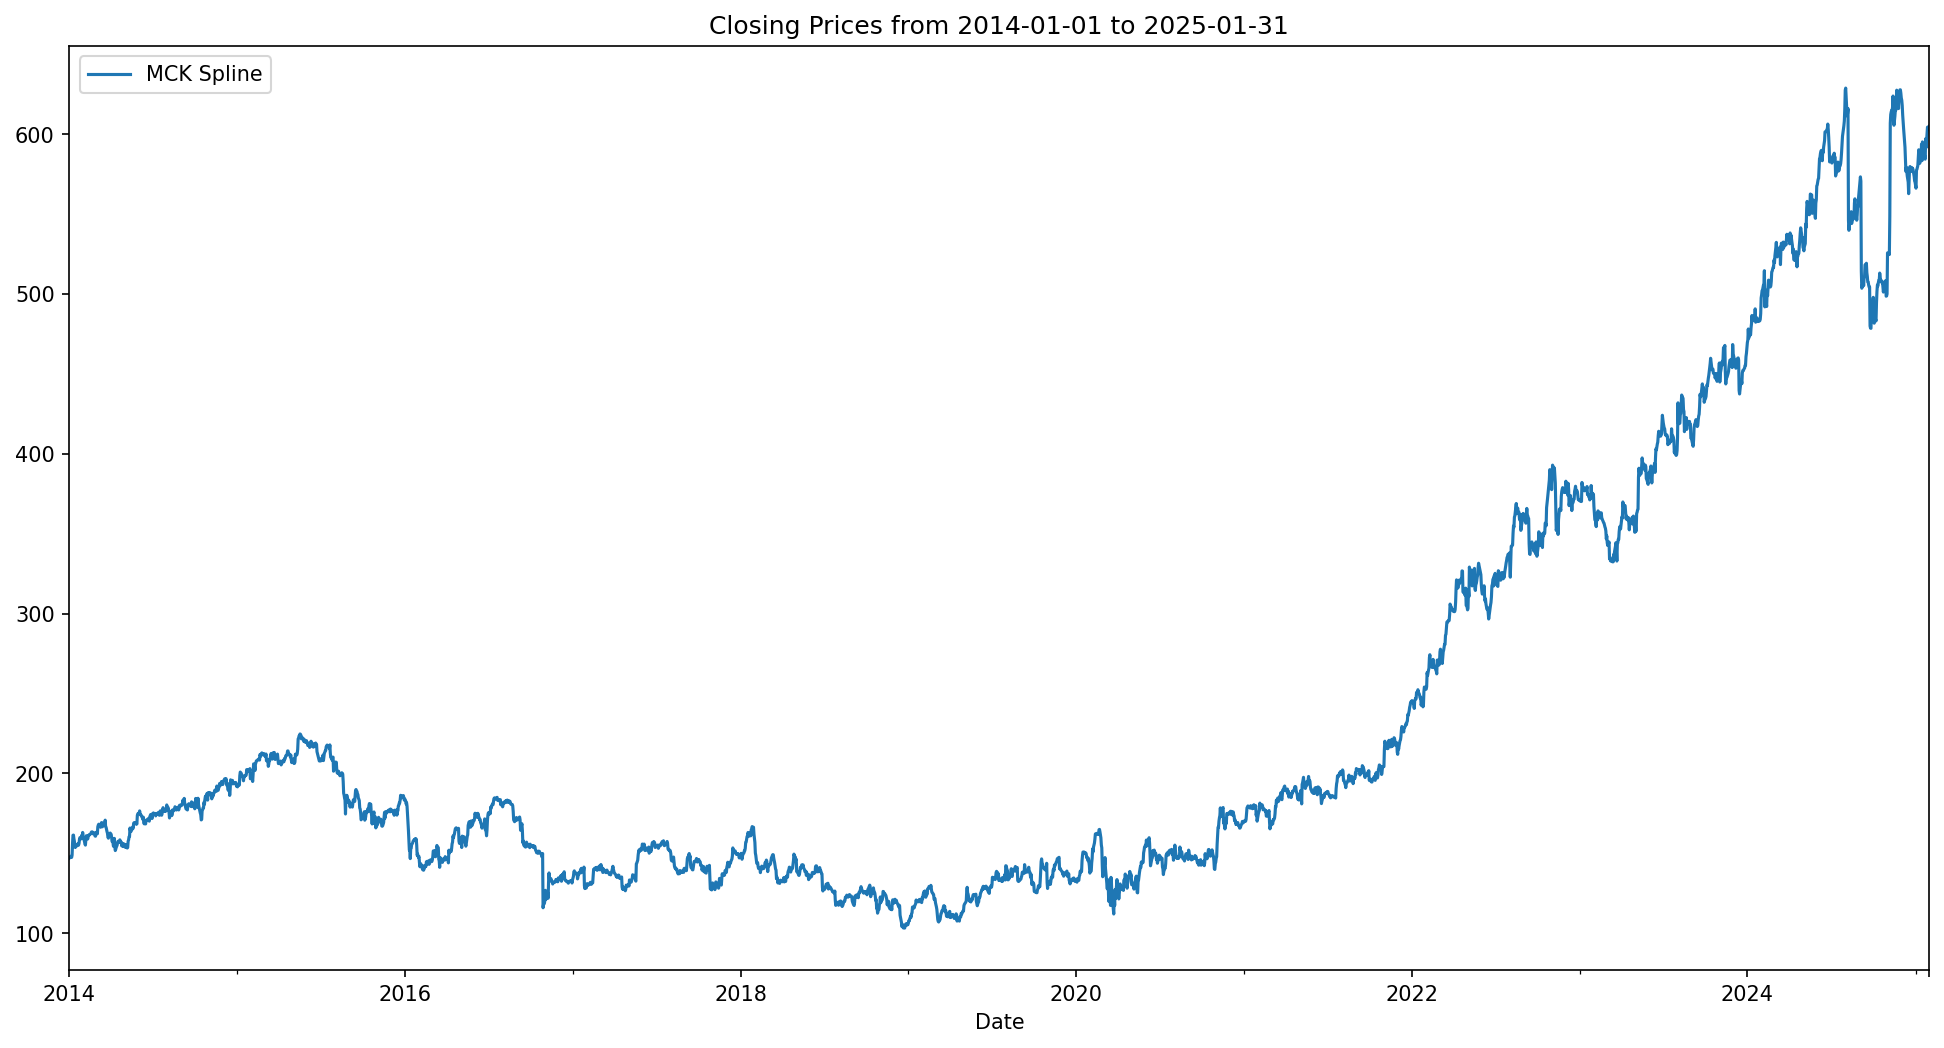

In [218]:
# choosing betwwen spline and linear methods
plt.figure(figsize=(16, 8), dpi=150)

#stock_df_imputed['MCK_Linear'].plot(label='MCK Linear', color = 'orange')
stock_df_imputed['MCK_Spline'].plot(label='MCK Spline')

plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

plt.xlabel('Date')

plt.legend()

### Data Visualization For Outliers

<Axes: xlabel='None', ylabel='MCK_Spline'>

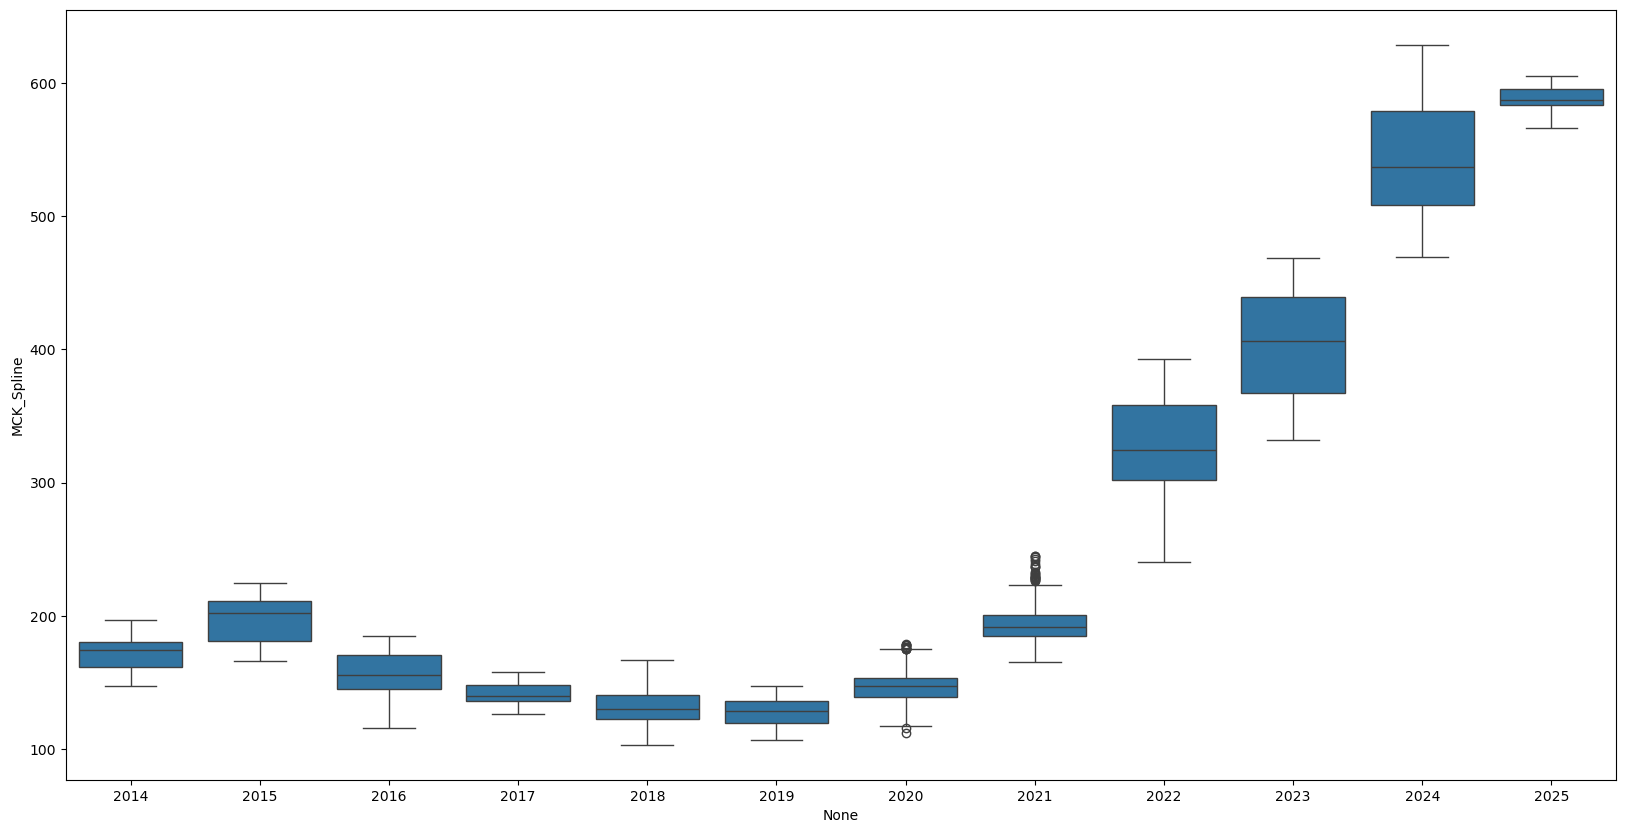

In [219]:
# price variation for each year

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_imputed.index.year,
                y = stock_df_imputed['MCK_Spline'],
                ax = ax)

<Axes: xlabel='None', ylabel='MCK_Spline'>

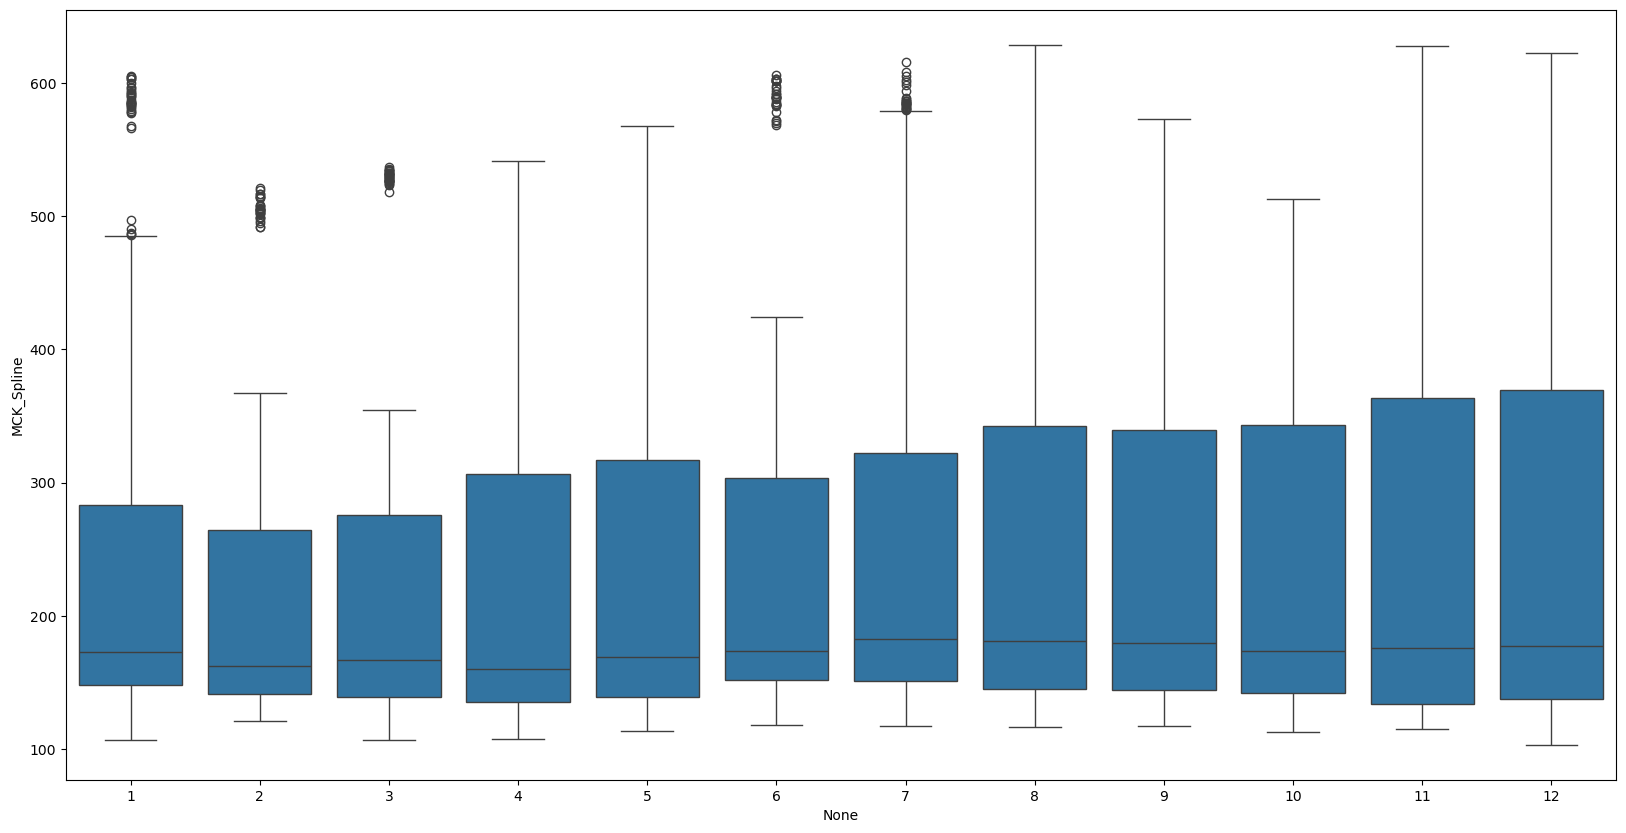

In [220]:
# price variation for each month

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_imputed.index.month,
                y = stock_df_imputed['MCK_Spline'],
                ax = ax)

### Resampling and writing data to csv

Resampling Data

In [221]:
df_resample = stock_df_imputed.copy()

# extract only the spline variables
df_resample = df_resample[['MCK_Spline']].round(2)
df_resample

,MCK_Spline
2014-01-01,146.96
2014-01-02,147.31
2014-01-03,147.82
2014-01-04,147.87
2014-01-05,148.17
...,...
2025-01-27,604.43
2025-01-28,602.95
2025-01-29,603.18
2025-01-30,604.60


In [222]:
# downsample the data from days to months to reduce variability in the data

df_resample_months = df_resample.groupby(pd.Grouper(freq='MS')).median()
df_resample_months

,MCK_Spline
2014-01-01,156.070
2014-02-01,161.255
2014-03-01,166.530
2014-04-01,156.585
2014-05-01,164.840
...,...
2024-09-01,507.510
2024-10-01,505.020
2024-11-01,614.900
2024-12-01,578.510


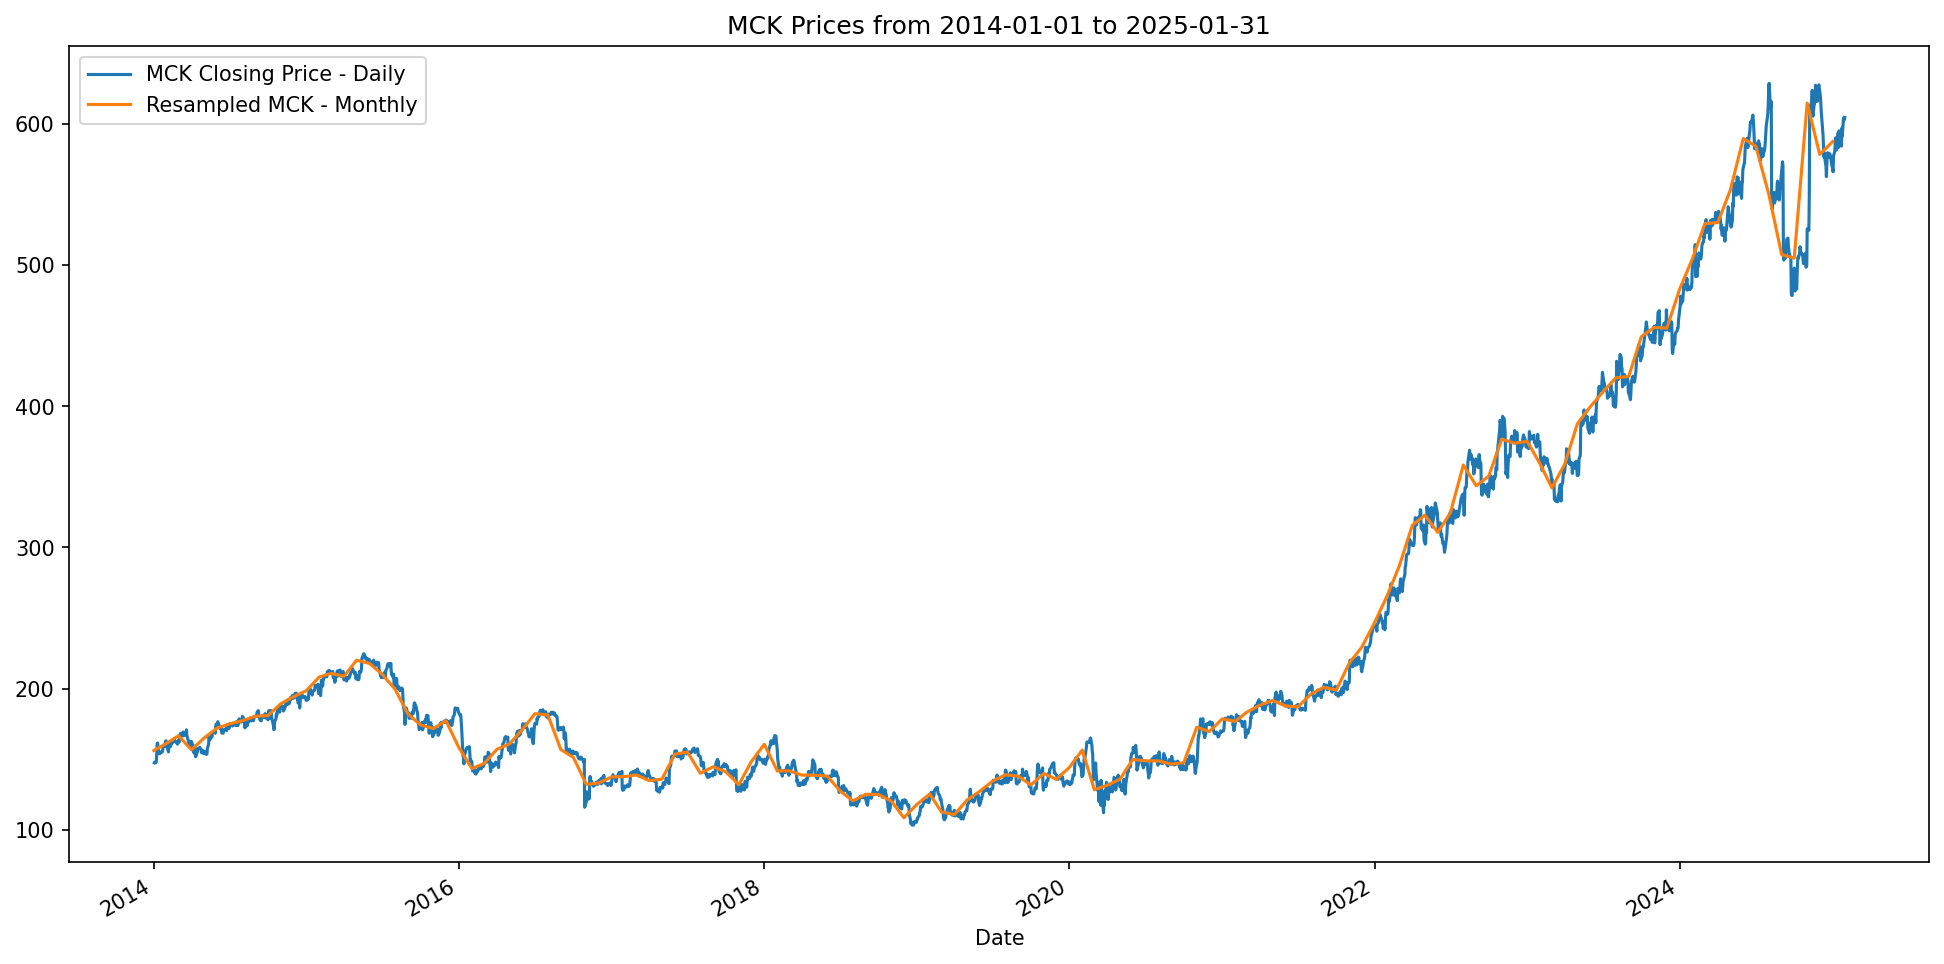

In [223]:
#Plot monthly data

plt.figure(figsize=(16, 8), dpi=150)

#df_resample_months['MSFT_Spline'].plot(label='MSFT')
stock_df['CloseMCK'].plot(label='MCK Closing Price - Daily')
df_resample_months['MCK_Spline'].plot(label='Resampled MCK - Monthly')

plt.title('MCK Prices from {} to {}'.format(stock_start_date, stock_end_date))

plt.xlabel('Date')

plt.legend()

Writing Data to CSV

In [ ]:
#df_resample_months.to_csv('/Users/madison/Downloads/resample.csv', index = True, header=True)

### Time Series Visualization For ACF

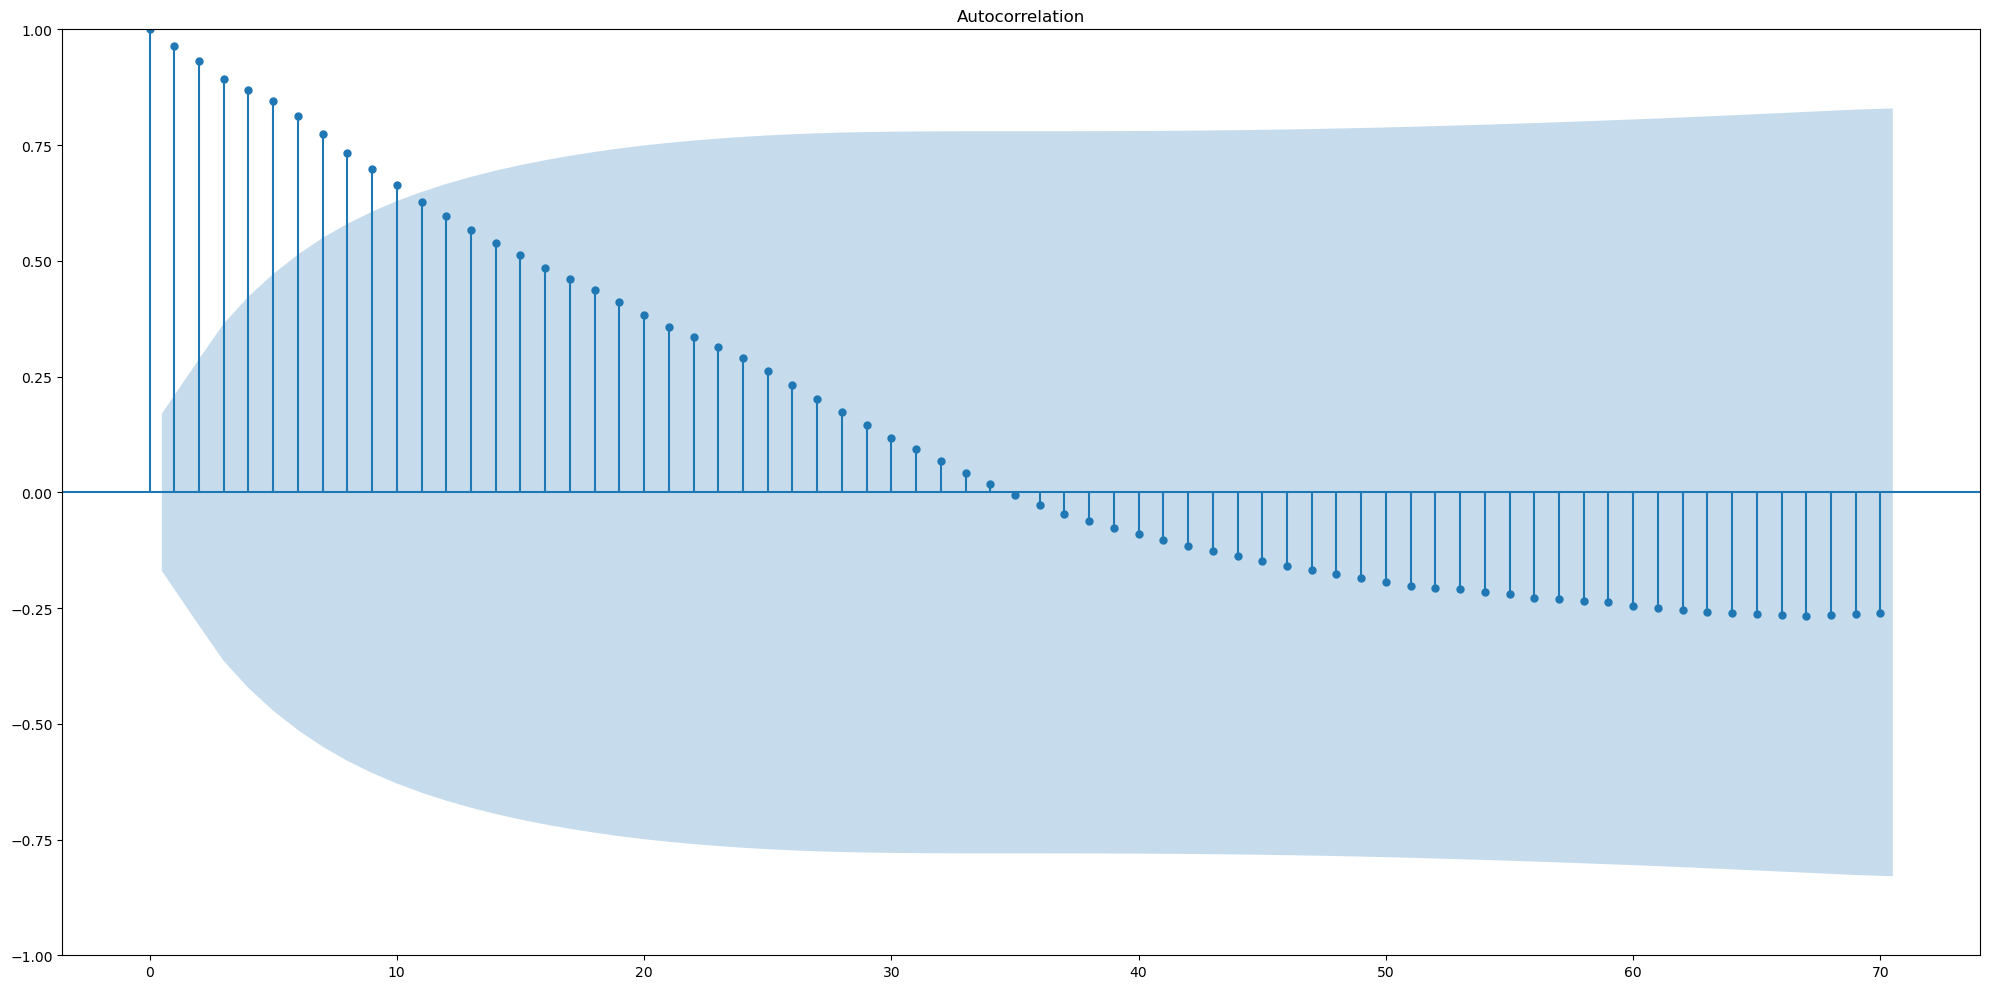

In [224]:
fig = plot_acf(df_resample_months['MCK_Spline'], lags=70)
fig.set_size_inches((20, 10))

fig.tight_layout()
plt.show()

### Time Series Visualization For Decomposition (Trend, Seasonality, and Residual)

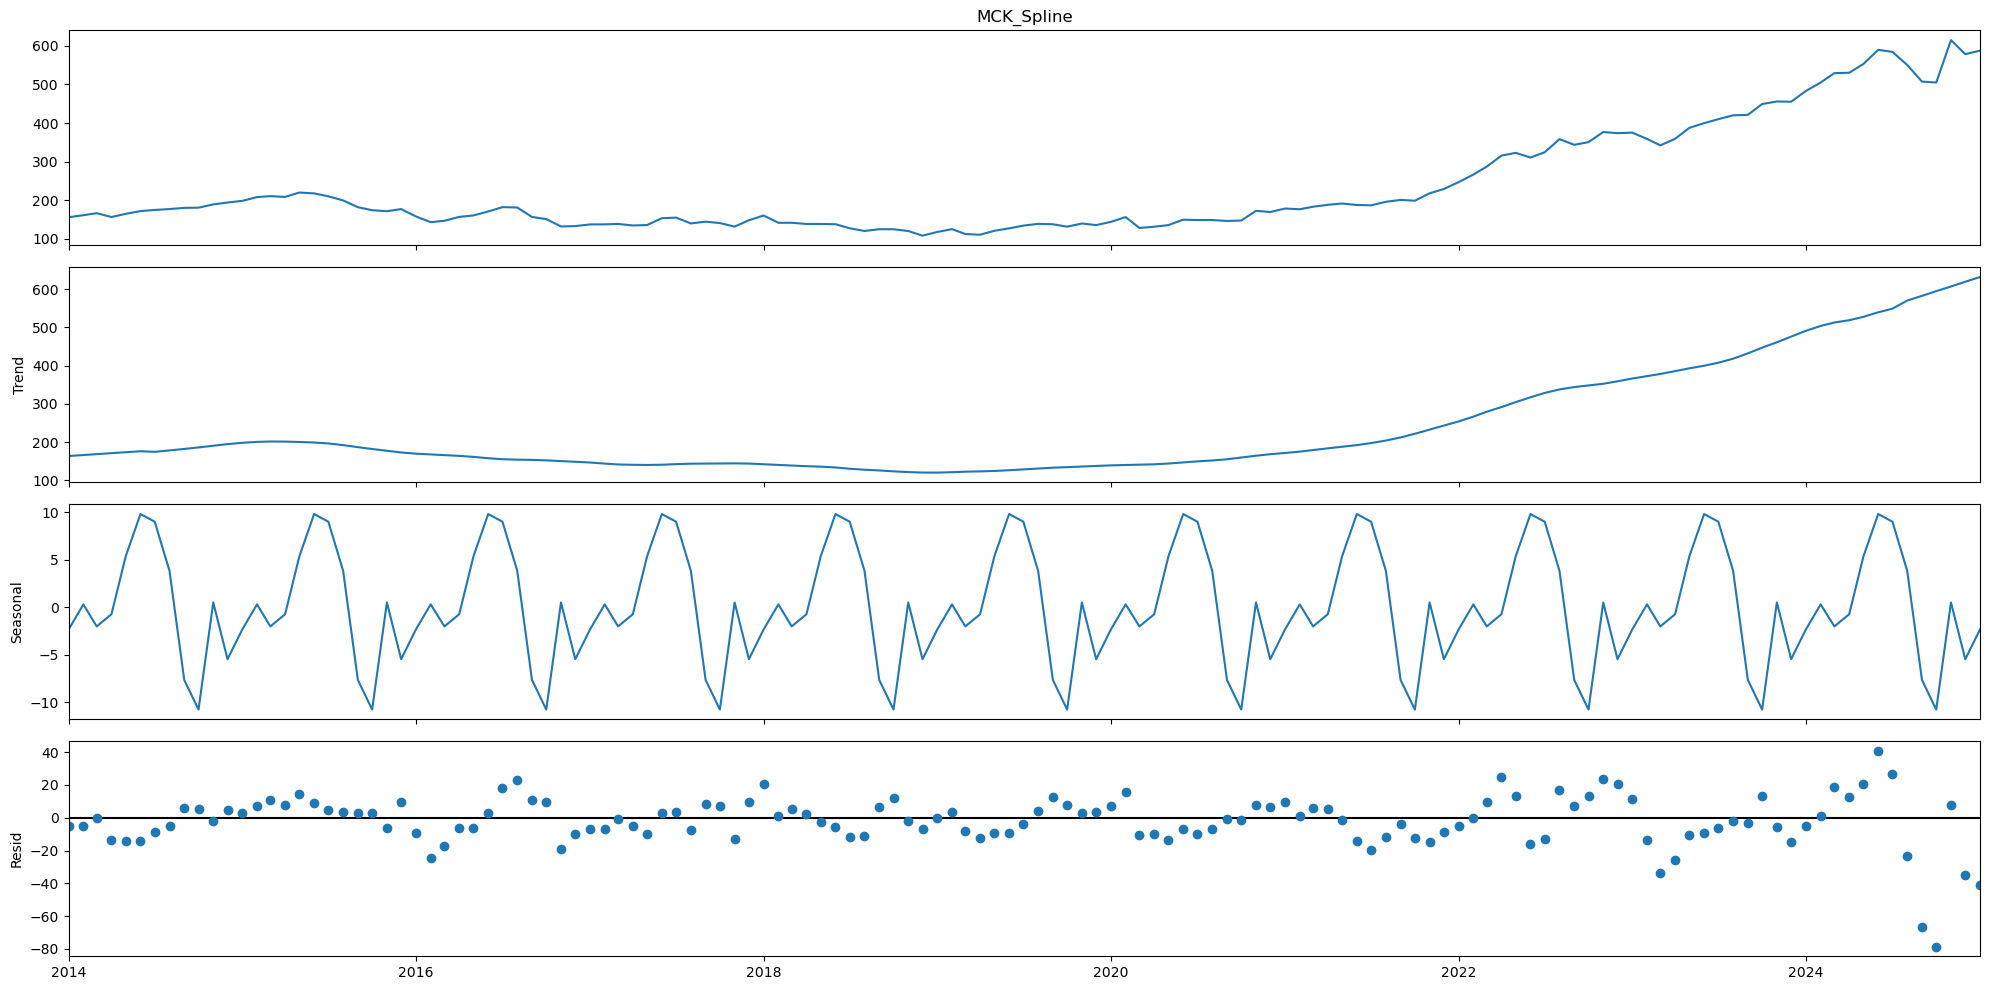

In [225]:
res = sm.tsa.seasonal_decompose(df_resample_months['MCK_Spline'], period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 10))

fig.tight_layout()
plt.show()

In [226]:
mck_df = df_resample_months[['MCK_Spline']]

mck_df['trend'] = res.trend
mck_df['seasonal'] = res.seasonal
mck_df['error'] = res.resid
mck_df

,MCK_Spline,trend,seasonal,error
2014-01-01,156.070,163.674398,-2.325198,-5.279199
2014-02-01,161.255,166.163743,0.314796,-5.223539
2014-03-01,166.530,168.653089,-2.004103,-0.118986
2014-04-01,156.585,171.142435,-0.723229,-13.834206
2014-05-01,164.840,173.631781,5.379236,-14.171017
...,...,...,...,...
2024-09-01,507.510,582.089674,-7.641880,-66.937794
2024-10-01,505.020,594.369754,-10.760864,-78.588890
2024-11-01,614.900,606.649834,0.518636,7.731530
2024-12-01,578.510,618.929915,-5.458171,-34.961744


<Axes: >

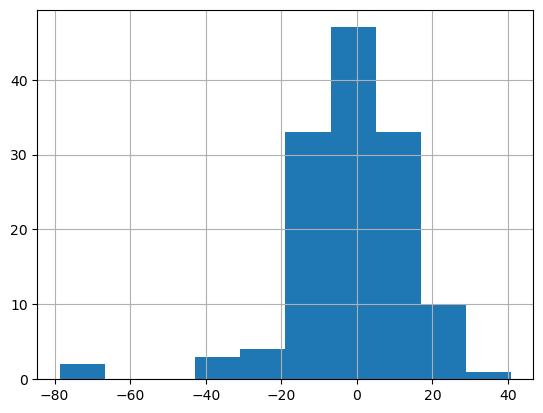

In [227]:
mck_df['error'].hist()

 ## Fitting Models: ETS Simple, double, and triple

In [228]:
mck = mck_df[['MCK_Spline']]
mck

,MCK_Spline
2014-01-01,156.070
2014-02-01,161.255
2014-03-01,166.530
2014-04-01,156.585
2014-05-01,164.840
...,...
2024-09-01,507.510
2024-10-01,505.020
2024-11-01,614.900
2024-12-01,578.510


In [229]:
from sklearn.model_selection import train_test_split

test_size = 12

train_data, test_data = train_test_split(mck, test_size=test_size, random_state=25, shuffle = False)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 121
No. of testing examples: 12


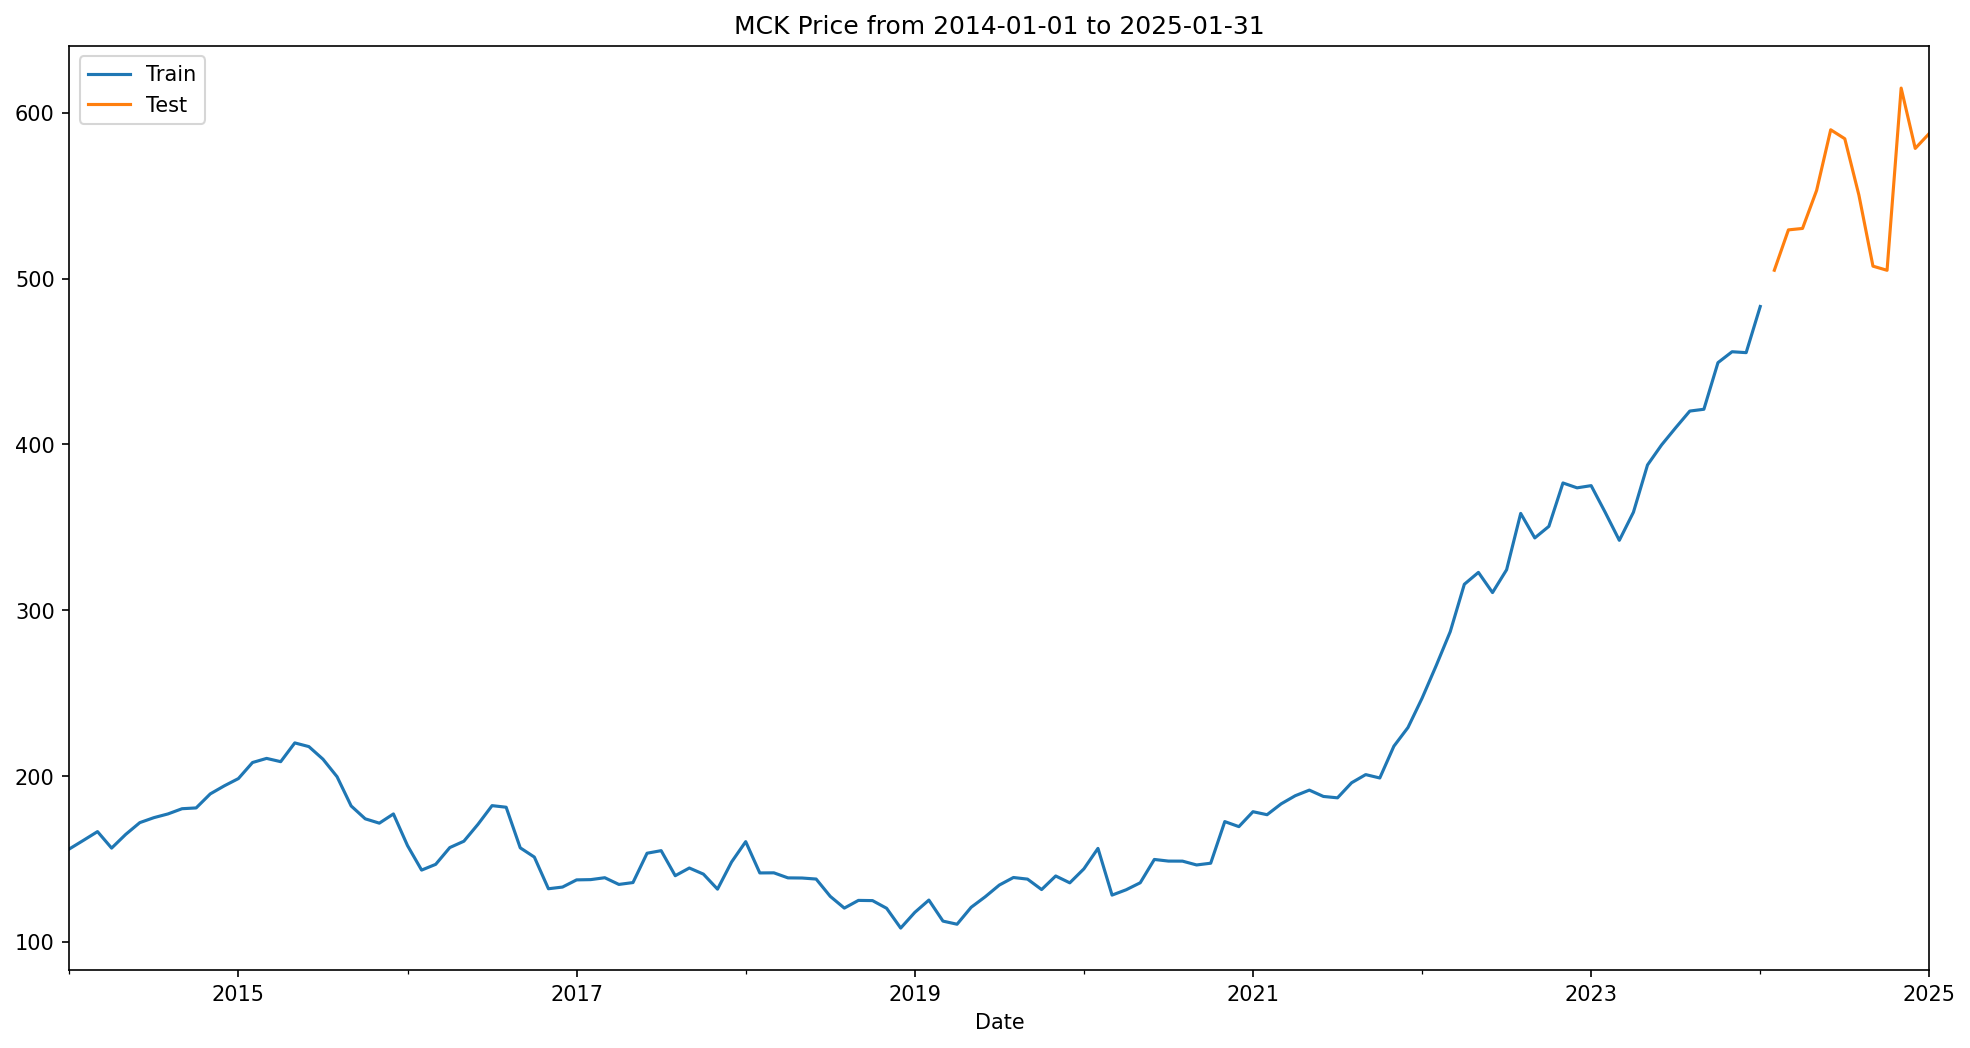

In [230]:
plt.figure(figsize=(16, 8), dpi=150)
train_data['MCK_Spline'].plot(label='Train')
test_data['MCK_Spline'].plot(label='Test')
plt.title('MCK Price from {} to {}'.format(stock_start_date, stock_end_date))
plt.xlabel('Date')
plt.legend()

### Fitting The ETS Models

Simple EST

In [231]:
#First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

#Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

#Third Instance
ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])

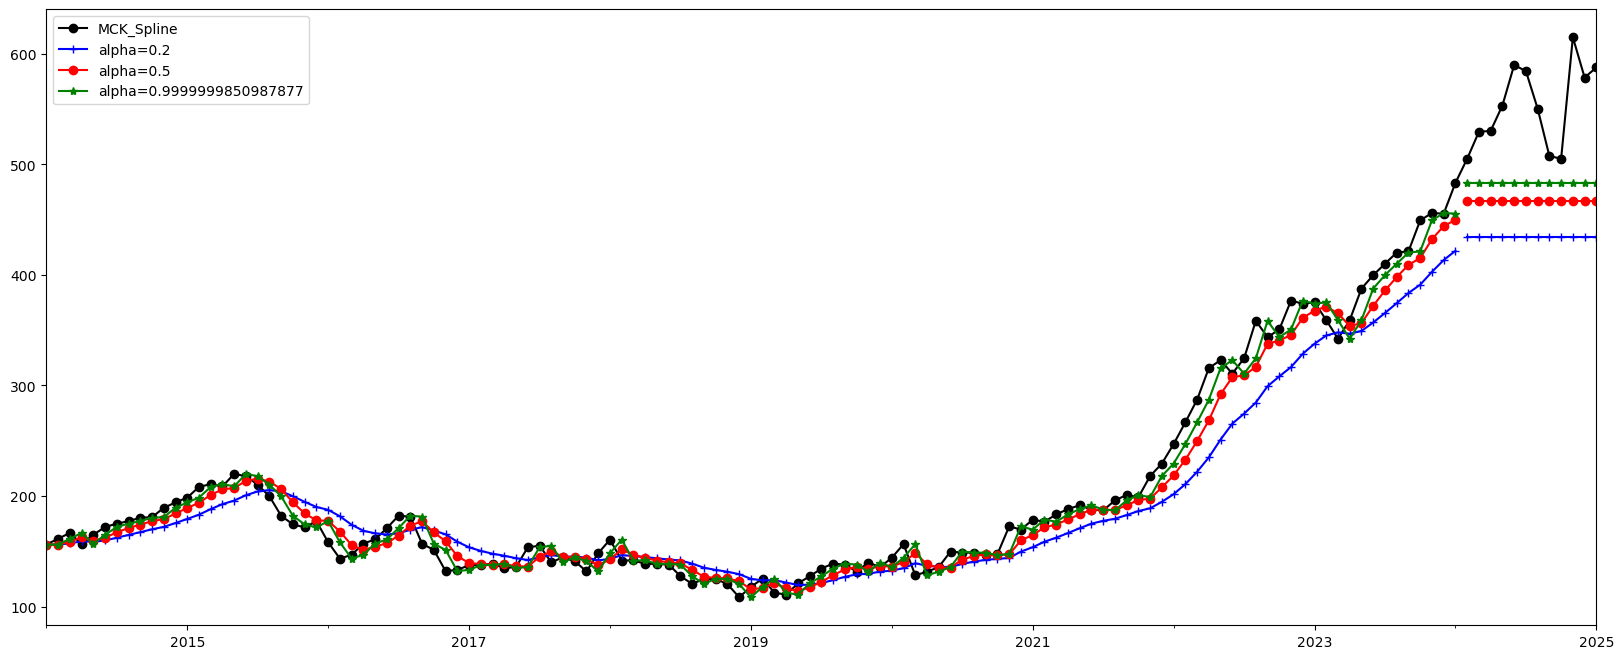

In [232]:
#After creating model we will visualize the plot
ax = mck.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

Double EST

In [233]:
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)

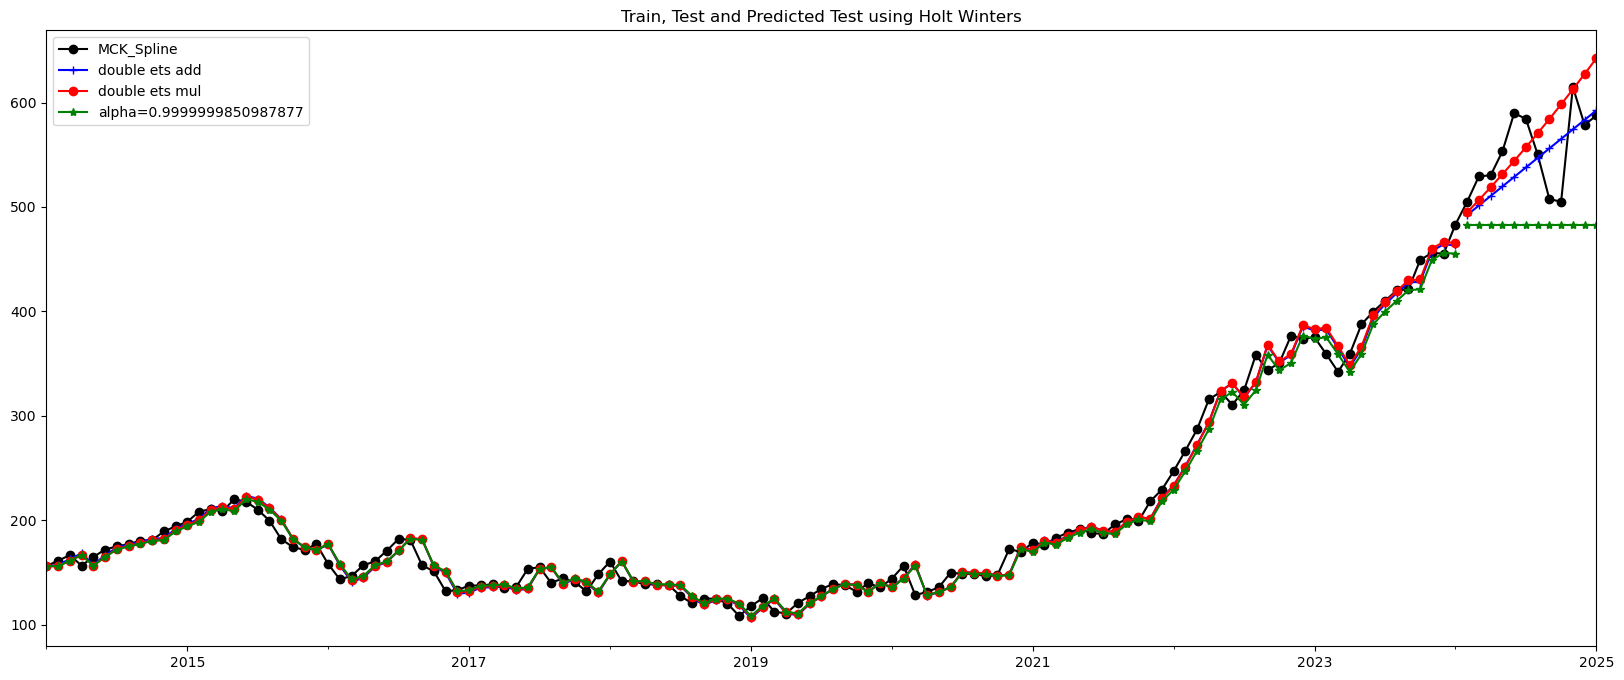

In [234]:
ax = mck.plot(marker='o', color='black', figsize=(20,8), legend=True)

double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

Triple EST

In [235]:
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

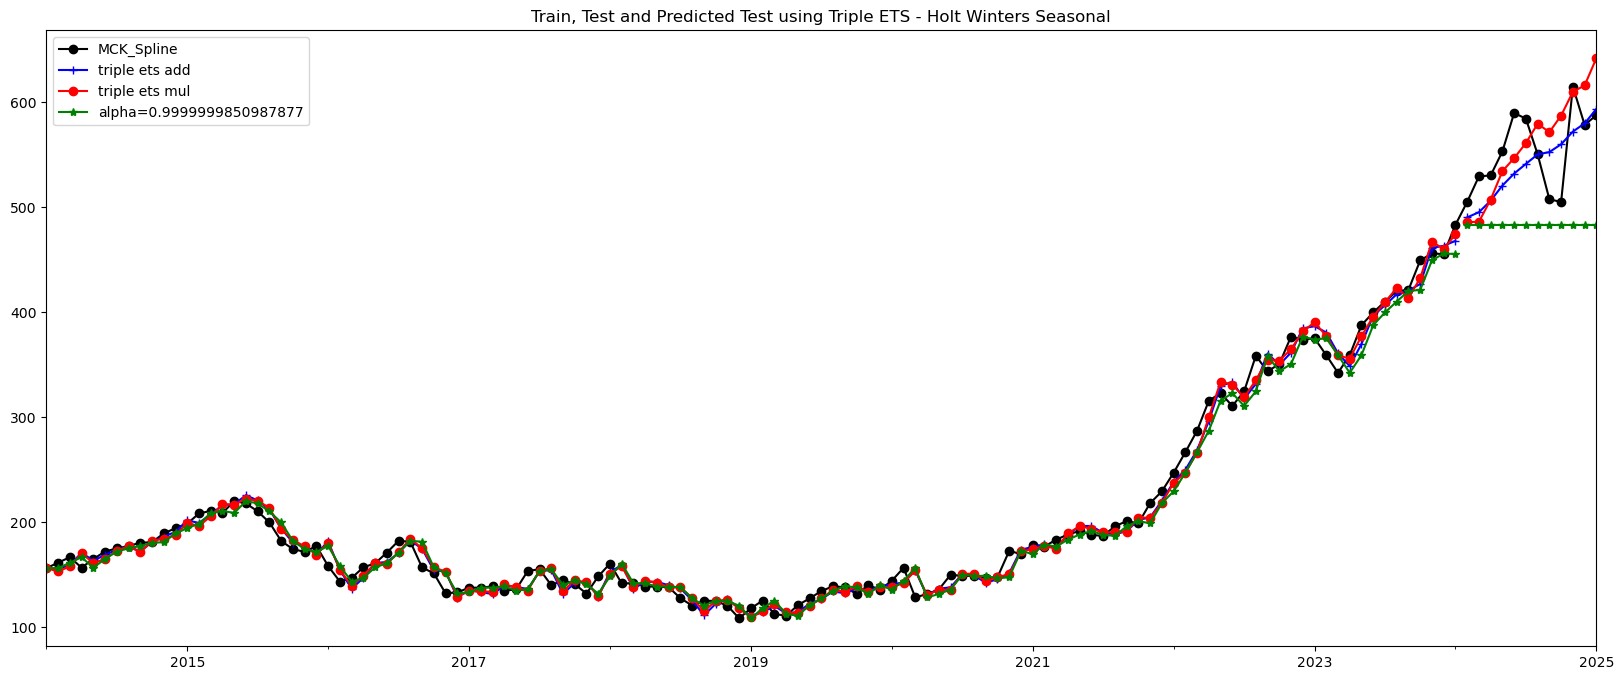

In [236]:
ax = mck.plot(marker='o', color='black', figsize=(20,8), legend=True)

triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

Calculating Residuals

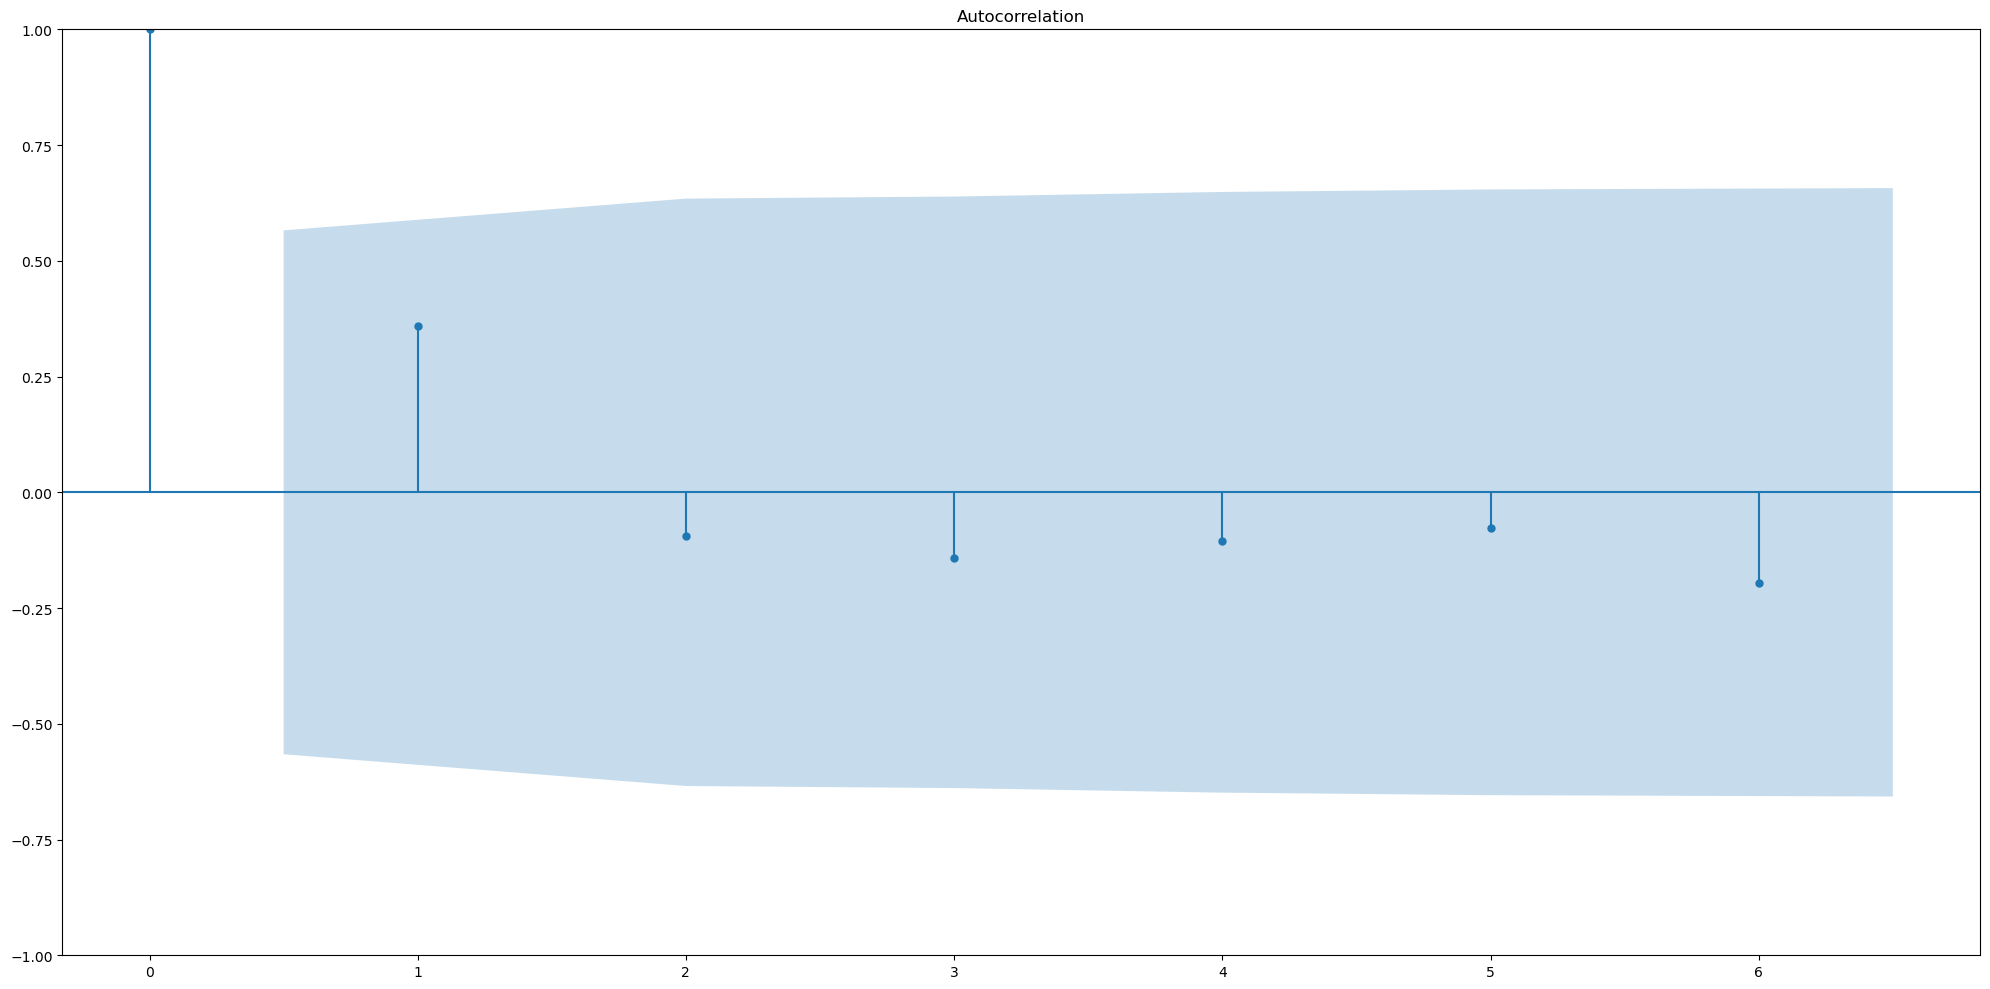

In [237]:
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)
fig = plot_acf(residuals)
fig.set_size_inches((20, 10))
fig.tight_layout()
plt.show()

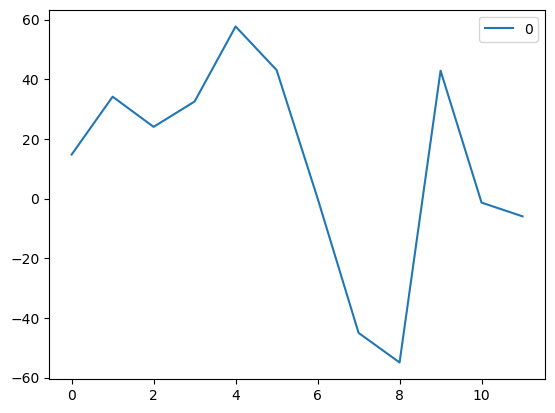

In [238]:
residuals.plot()
plt.show()

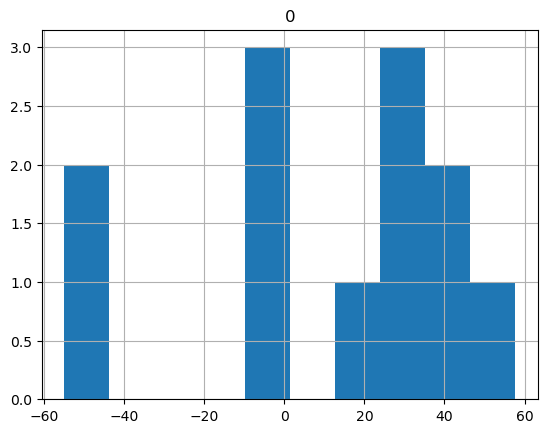

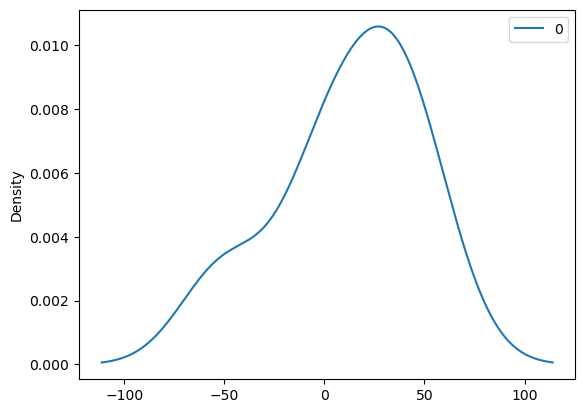

In [239]:
# histogram plot
residuals.hist()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.show()

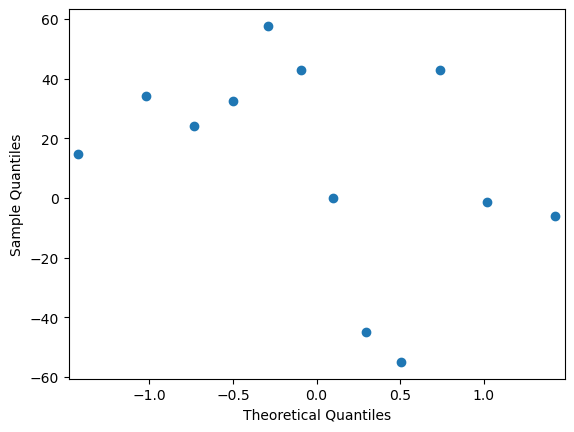

In [240]:
qqplot(residuals)
plt.show()

## Evaluating the Models Using Metrics: MAE, RMSE, MASE, MAPE, and SMAPE

2 additional metrics chosen: MASE and SMAPE

I chose those two metrics for the following reasons:

MASE is a robust metric that compares the forecast errors of your model to the errors of a naive benchmark (e.g., a simple seasonal naive model). It is scale-independent, making it ideal for comparing models across datasets with different scales. MASE is particularly useful for time series data because it accounts for seasonality and trend, ensuring fair evaluation even when the data has complex patterns. A MASE value less than 1 indicates that your model outperforms the naive benchmark.

SMAPE measures the percentage error between actual and predicted values, but unlike MAPE, it is symmetric, meaning it treats over- and under-predictions equally. This makes SMAPE more balanced and less biased when dealing with small or zero values in the data. It is especially useful for datasets with varying magnitudes, as it provides a normalized error measure that is easy to interpret.

In [241]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MASE', 'MAPE', 'SMAPE'])

def metrics_cal(actuals, predictions, model):
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mase = mae/(np.mean(np.abs(actuals[1:] - actuals[:-1])))
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    smape = 2 * np.mean(np.abs(actuals - predictions) / (np.abs(actuals) + np.abs(predictions))) * 100

    df = pd.DataFrame({'Model': [model],
                       'MAE': [mae],
                       'MSE': [mse],
                       'RMSE': [rmse],
                       'MASE':[mase],
                       'MAPE': [mape],
                       'SMAPE': [smape]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe

In [242]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast1.values.flatten(),
                                'Simple 0.2')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast2.values.flatten(),
                                'Simple 0.5')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast3.values.flatten(),
                                'Simple 1')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_add_pred.values.flatten(),
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_mul_pred.values.flatten(),
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')

C:\Users\madison\AppData\Local\Temp\ipykernel_13120\3213428890.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


In [243]:
metrics_dataframe.sort_values(by='MAE')

,Model,MAE,RMSE,MASE,MAPE,SMAPE,MSE
5,Triple Add,29.709518,35.505526,1.006234,5.411098,5.464115,1260.642362
3,Double Add,30.344961,36.555505,1.027756,5.524663,5.562012,1336.304920
4,Double Mul,36.253433,45.105418,1.227870,6.681946,6.448700,2034.498745
6,Triple Mul,36.900226,42.437490,1.249777,6.810654,6.661886,1800.940517
2,Simple 1,69.804167,78.653282,2.364203,12.246453,13.245124,6186.338795
1,Simple 0.5,86.541984,93.825541,2.931097,15.286257,16.746911,8803.232076
0,Simple 0.2,118.942110,124.342039,4.028460,21.170538,23.863446,15460.942681


### Choosing the best-performed model(s) and the reasonings

Mean Absolute Error (MAE):
Lower is better. MAE measures the average magnitude of errors in a set of predictions, without considering their direction.
Triple Add has the lowest MAE (29.702627), indicating it has the smallest average error.

Root Mean Squared Error (RMSE):
Lower is better. RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It gives a relatively high weight to large errors.
Triple Add also has the lowest RMSE (35.389382), suggesting it has the smallest deviations from the actual values.

Mean Absolute Scaled Error (MASE):
Lower is better. MASE is a metric that compares the forecast error to the error of a naive forecast.
Triple Add has the lowest MASE (1.005706), indicating it performs better than a naive model.

Mean Absolute Percentage Error (MAPE):
Lower is better. MAPE measures the size of the error in percentage terms.
Triple Add has the lowest MAPE (5.409463), showing it has the smallest percentage error.

Symmetric Mean Absolute Percentage Error (SMAPE):
Lower is better. SMAPE is similar to MAPE but symmetric and bounded.
Triple Add has the lowest SMAPE (5.457829), indicating better performance in terms of percentage error.

Mean Squared Error (MSE):
Lower is better. MSE measures the average of the squares of the errors.
Triple Add has the lowest MSE (1252.408342), suggesting it has the smallest squared errors.

Based on the evaluation metrics provided, the Triple Add model consistently performs better across all metrics. It has the lowest values in MAE, RMSE, MASE, MAPE, SMAPE, and MSE, indicating it has the smallest errors and deviations from the actual values. Therefore, the Triple Add model is the best-performing model among the ones listed. The Double Add model is the second-best performer, with slightly higher values across all metrics compared to the Triple Add model. The other models have much higher errors and are less accurate.

In [244]:
mck.tail(12).mean()

MCK_Spline    552.994167
dtype: float64

In [245]:
triple_ets_add_pred.values.flatten()

array([490.29069081, 495.22954854, 506.20700022, 520.62912664,
       532.05830448, 541.2768865 , 550.32887845, 552.52789957,
       559.95208835, 572.02076685, 579.8542879 , 593.53113758])

In [246]:
# Create a data frame with all the predictions along with the test data
test_pred_df = test_data.copy()

# Add all predictions
test_pred_df = test_pred_df.assign(triple_ets_add_pred = triple_ets_add_pred.values.flatten(),
                                   double_ets_add_pred = double_ets_add_pred.values.flatten())

test_pred_df

,MCK_Spline,triple_ets_add_pred,double_ets_add_pred
2024-02-01,505.050,490.290691,492.294744
2024-03-01,529.390,495.229549,501.399495
2024-04-01,530.255,506.207000,510.504246
2024-05-01,553.180,520.629127,519.608997
2024-06-01,589.755,532.058304,528.713748
2024-07-01,584.360,541.276886,537.818499
2024-08-01,550.420,550.328878,546.923250
2024-09-01,507.510,552.527900,556.028001
2024-10-01,505.020,559.952088,565.132752
2024-11-01,614.900,572.020767,574.237503


In [247]:
test_pred_df['Average_Predictions'] = (test_pred_df['triple_ets_add_pred']+test_pred_df['double_ets_add_pred'])/2
test_pred_df

,MCK_Spline,triple_ets_add_pred,double_ets_add_pred,Average_Predictions
2024-02-01,505.050,490.290691,492.294744,491.292717
2024-03-01,529.390,495.229549,501.399495,498.314522
2024-04-01,530.255,506.207000,510.504246,508.355623
2024-05-01,553.180,520.629127,519.608997,520.119062
2024-06-01,589.755,532.058304,528.713748,530.386026
2024-07-01,584.360,541.276886,537.818499,539.547693
2024-08-01,550.420,550.328878,546.923250,548.626064
2024-09-01,507.510,552.527900,556.028001,554.277950
2024-10-01,505.020,559.952088,565.132752,562.542420
2024-11-01,614.900,572.020767,574.237503,573.129135


In [248]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                test_pred_df['Average_Predictions'].values.flatten(),
                                'Average')

metrics_dataframe.sort_values(by='MAE')

,Model,MAE,RMSE,MASE,MAPE,SMAPE,MSE
5,Triple Add,29.709518,35.505526,1.006234,5.411098,5.464115,1260.642362
7,Average,30.027239,35.989887,1.016995,5.467881,5.512857,1295.271945
3,Double Add,30.344961,36.555505,1.027756,5.524663,5.562012,1336.304920
4,Double Mul,36.253433,45.105418,1.227870,6.681946,6.448700,2034.498745
6,Triple Mul,36.900226,42.437490,1.249777,6.810654,6.661886,1800.940517
2,Simple 1,69.804167,78.653282,2.364203,12.246453,13.245124,6186.338795
1,Simple 0.5,86.541984,93.825541,2.931097,15.286257,16.746911,8803.232076
0,Simple 0.2,118.942110,124.342039,4.028460,21.170538,23.863446,15460.942681


After adding Average Model, the Triple Add is still the best performer, while the Average Model is the second best performer.

## Forecasting the Future MCK Stock Price Using the Best-Performed Model

In [252]:
# Forecast the next 12 months using the best-performed Model Triple Add
triple_ets_add_forecast = ExponentialSmoothing(mck, trend='add', seasonal='add', seasonal_periods=12).fit()

In [253]:
triple_ets_add_pred_2025 = triple_ets_add_forecast.forecast(12)
triple_ets_add_pred_2025

2025-02-01    594.871615
2025-03-01    600.252925
2025-04-01    608.995097
2025-05-01    622.879281
2025-06-01    635.287921
2025-07-01    641.876048
2025-08-01    645.722122
2025-09-01    642.526846
2025-10-01    647.762649
2025-11-01    667.440424
2025-12-01    669.975748
2026-01-01    681.942418
Freq: MS, dtype: float64

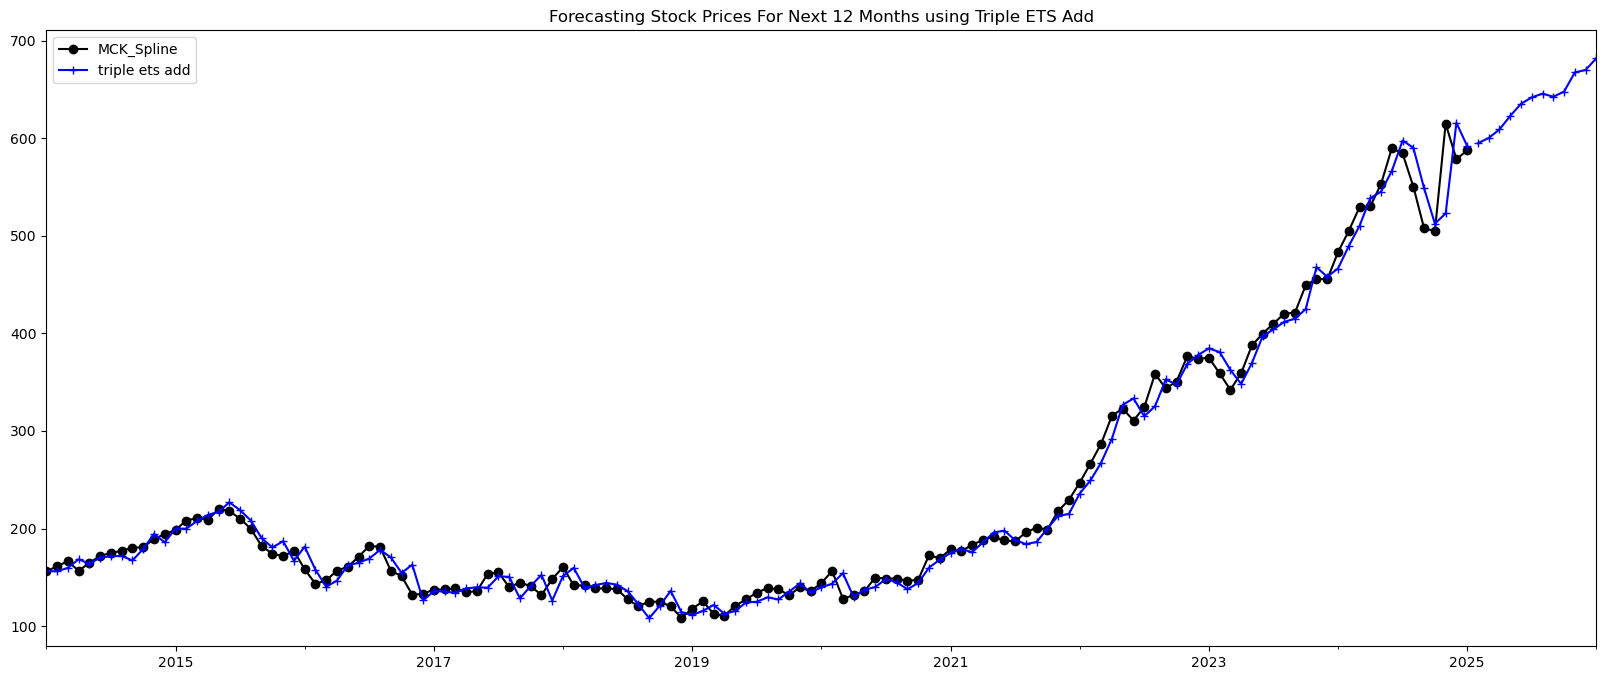

In [255]:
ax = mck.plot(marker='o', color='black', figsize=(20,8), legend=True)

triple_ets_add_pred_2025.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add_forecast.fittedvalues.plot(marker='+', ax=ax, color='blue')

plt.title('Forecasting Stock Prices For Next 12 Months using Triple ETS Add')
plt.show()